In [41]:
################################################################################
#
# Scrape 2018 House Election Data from NYTimes
#
################################################################################

import requests
from bs4 import BeautifulSoup
import json
import csv

path = "../ElectionData/ListOfHouseDistricts.csv"
districts = set()
with open(path) as file:
    reader = csv.reader(file)
    for row in reader:
        districts.add((row[0], row[1]))

missing_district_dem = []
missing_district_rep = []
missing_county = districts.copy()
incomplete_county = set()
inconsistent_district_county = []

with open("2018HouseDistrict_NYTScrape.csv", "w") as district_output:
    district_writer = csv.writer(district_output, lineterminator="\n")
    district_writer.writerow(['state','district','district_dem_result','district_rep_result'])
    
    with open("2018HouseCounty_NYTScrape.csv", "w") as county_output:
        county_writer = csv.writer(county_output, lineterminator="\n")
        county_writer.writerow(['state_id','race_name','seat','fips','name','county_dem_result','county_rep_result','reporting','precincts'])
    
        for district in districts:
        #district = ('North Carolina','1')
        #url = 'https://www.nytimes.com/elections/results/north-carolina-house-district-1'
            url = 'https://www.nytimes.com/elections/results/' + district[0].lower().replace(" ", "-") + "-house-district-" + district[1].lower().replace(" ", "-")
            response = requests.get(url)
            html = response.content

            ########## Scrape District Level Results ##########
            district_results = []

            start_district_dem_keystring = '<span class="eln-party-abbr">Dem.</span></td><td class="eln-cell eln-votes">'
            end_district_dem_keystring = '</td>'
            start_district_dem_index = html.find(start_district_dem_keystring)
            if start_district_dem_index == -1:
                missing_district_dem.append(district)
                district_results.append(0)
                #print(district)
            else:
                start_district_dem_index += len(start_district_dem_keystring)
                end_district_dem_index = html.find(end_district_dem_keystring,start_district_dem_index)
                #print(html)
                district_dem_result = html[start_district_dem_index:end_district_dem_index].replace(',', '')
                #print(district_dem_result)
                district_results.append(district_dem_result)

            start_district_rep_keystring = '<span class="eln-party-abbr">Rep.</span></td><td class="eln-cell eln-votes">'
            end_district_rep_keystring = '</td>'
            start_district_rep_index = html.find(start_district_rep_keystring)
            if start_district_rep_index == -1:
                missing_district_rep.append(district)
                district_results.append(0)
                #print(district)
            else:
                start_district_rep_index += len(start_district_rep_keystring)
                end_district_rep_index = html.find(end_district_rep_keystring,start_district_rep_index)
                district_rep_result = html[start_district_rep_index:end_district_rep_index].replace(',', '')
                #print(district_rep_result)
                district_results.append(district_rep_result)

            #district_writer.writerow([district[0],district[1],district_results[0],district_results[1]])

            ########## Scrape County Level Results ##########
            soup = BeautifulSoup(html, features="lxml")

            start_county_keystring = "eln_races ="
            end_county_keystring = "eln_forecast_feed"
            scripts = soup.find_all('script')
            for script in scripts:
                if "eln_races" in str(script):
                    missing_county.remove(district)

                    start_county_index = script.string.find(start_county_keystring)
                    end_county_index = script.string.find(end_county_keystring)
                    county_result_raw = script.string[start_county_index+len(start_county_keystring):end_county_index].strip()[1:-2].encode('utf-8').strip()

                    #County Result Object for District
                    d = json.loads(county_result_raw)

                    #Format County Results by Aggregating All Same Party Candidates
                    dem_candidates = []
                    rep_candidates = []
                    for candidate in d['candidates']:
                        if candidate['party_id'] == "democrat":
                            dem_candidates.append(str(candidate['candidate_key']))
                        if candidate['party_id'] == "republican":
                            rep_candidates.append(str(candidate['candidate_key']))
                    county_district_dem_result = 0
                    county_district_rep_result = 0
                    for county in d['counties']:
                        if county['reporting'] != county['precincts']:
                            incomplete_county.add(district)
                        county_dem_result = 0
                        for demcandidate in dem_candidates:
                            county_dem_result += county['results'][demcandidate]
                            county_district_dem_result += county['results'][demcandidate]
                        county_rep_result = 0
                        for repcandidate in rep_candidates:
                            county_rep_result += county['results'][repcandidate]
                            county_district_rep_result += county['results'][repcandidate]
                        county_writer.writerow([d['state_id'],d['race_name'],d['seat'],county['fips'],county['name'],county_dem_result,county_rep_result,county['reporting'],county['precincts']])
                    if county_district_dem_result != int(district_dem_result) or county_district_rep_result != int(district_rep_result):
                        inconsistent_district_county.append(district)
                    
                    district_writer.writerow([district[0],district[1],county_district_dem_result,county_district_rep_result])

#Summary of Scraping
print("Completed Scraping NYTimes for " + str(len(districts)) + " Districts")
print("Number of Districts with Missing District Level Demorcat Result:",len(missing_district_dem))
print("Number of Districts with Missing District Level Republican Result:",len(missing_district_rep))
print("Number of Districts Unable to Scrape County Level Results:",len(missing_county))
print("Number of Districts with Not All Precincts Reporting:",len(incomplete_county))
print("Number of Districts with Inconsistent Results at District and Aggregated County Level:",len(inconsistent_district_county))



Completed Scraping NYTimes for 435 Districts
Number of Districts with Missing District Level Demorcat Result: 20
Number of Districts with Missing District Level Republican Result: 40
Number of Districts Unable to Scrape County Level Results: 12
Number of Districts with Not All Precincts Reporting: 0
Number of Districts with Inconsistent Results at District and Aggregated County Level: 33


In [42]:
print("Missing District Level Demorcat Result:")
print(missing_district_dem)
print()
print("Missing District Level Republican Result:")
print(missing_district_rep)
print()
print("Unable to Scrape County Level Results:")
print(missing_county)
#print()
#print("Inconsistent Results at District and Aggregated County Level:")
#print(inconsistent_district_county)

Missing District Level Demorcat Result:
[('California', '8'), ('North Carolina', '3'), ('Florida', '14'), ('Florida', '20'), ('Georgia', '8'), ('New York', '16'), ('Massachusetts', '4'), ('Florida', '10'), ('Massachusetts', '7'), ('Florida', '24'), ('Massachusetts', '8'), ('Massachusetts', '1'), ('New York', '5'), ('Virginia', '3'), ('Wisconsin', '2'), ('Georgia', '5'), ('Florida', '21'), ('Alabama', '7'), ('Pennsylvania', '18'), ('Alaska', 'At Large')]

Missing District Level Republican Result:
[('New York', '8'), ('California', '20'), ('California', '27'), ('North Carolina', '3'), ('Florida', '14'), ('California', '40'), ('Texas', '30'), ('California', '13'), ('Washington', '2'), ('Florida', '20'), ('Georgia', '8'), ('New York', '16'), ('Texas', '28'), ('California', '6'), ('Massachusetts', '4'), ('Florida', '10'), ('California', '34'), ('Washington', '9'), ('Massachusetts', '7'), ('Michigan', '13'), ('Mississippi', '2'), ('Florida', '24'), ('Massachusetts', '8'), ('California', '5')

In [43]:
########## Aggregate Scraped County Level Results by County ##########

county_level_results = []
with open("2018HouseCounty_NYTScrape.csv", "r") as county_input:
    reader = csv.reader(county_input)
    header = reader.next()
    for row in reader:
        county_level_results.append(row)
    
with open("2018HouseCountyAggregated_NYTScrape.csv","w") as county_output:
    writer = csv.writer(county_output, lineterminator="\n")
    writer.writerow([header[0],header[3],header[4],header[5],header[6]])
    
    aggregated_counties = []
    for row in county_level_results:
        if row[3] not in aggregated_counties:
            cum_dem_results = 0
            cum_rep_results = 0
            for i in county_level_results:
                if row[3] == i[3]:
                    cum_dem_results += int(i[5])
                    cum_rep_results += int(i[6])
            writer.writerow([row[0],row[3],row[4],cum_dem_results,cum_rep_results])
            aggregated_counties.append(row[3])

print("Total Counties Aggregated:",len(aggregated_counties))

Total Counties Aggregated: 3055


In [51]:
################################################################################
#
# Imputing House Election Data for Missing Values and Uncontested Races
#
################################################################################
import pandas as pd

AllCountyCensusDataFilePath = "../CensusData/CensusDemographicProfileData2010/CountyLevel/DEC_10_DP_DPDP1/DEC_10_DP_DPDP1_with_ann.csv"
countyCensusData = pd.read_csv(AllCountyCensusDataFilePath, skiprows=[1])

listOfCountyIds = countyCensusData.iloc[:,1].values
listOfCountyNames = countyCensusData.iloc[:,2].values
countyDict = dict(zip(listOfCountyIds, listOfCountyNames))

PresidentialElectionDataFilePath = "../ElectionData/US_County_Level_Election_Results_08-16/US_County_Level_Presidential_Results_08-16.csv"
presidentialElectionData = pd.read_csv(PresidentialElectionDataFilePath)

HouseElectionDataFilePath = "2018HouseCountyAggregated_NYTScrape.csv"
houseElectionData = pd.read_csv(HouseElectionDataFilePath)

In [52]:
# Identify Counties Not in 2008 Presidential Results Dataset
for cid in listOfCountyIds:
    if cid not in presidentialElectionData.iloc[:,0].values:
        print(countyDict[cid])

Aleutians East Borough, Alaska
Aleutians West Census Area, Alaska
Anchorage Municipality, Alaska
Bethel Census Area, Alaska
Bristol Bay Borough, Alaska
Denali Borough, Alaska
Dillingham Census Area, Alaska
Fairbanks North Star Borough, Alaska
Haines Borough, Alaska
Hoonah-Angoon Census Area, Alaska
Juneau City and Borough, Alaska
Kenai Peninsula Borough, Alaska
Ketchikan Gateway Borough, Alaska
Kodiak Island Borough, Alaska
Lake and Peninsula Borough, Alaska
Matanuska-Susitna Borough, Alaska
Nome Census Area, Alaska
North Slope Borough, Alaska
Northwest Arctic Borough, Alaska
Petersburg Census Area, Alaska
Prince of Wales-Hyder Census Area, Alaska
Sitka City and Borough, Alaska
Skagway Municipality, Alaska
Southeast Fairbanks Census Area, Alaska
Valdez-Cordova Census Area, Alaska
Wade Hampton Census Area, Alaska
Wrangell City and Borough, Alaska
Yakutat City and Borough, Alaska
Yukon-Koyukuk Census Area, Alaska
Kalawao County, Hawaii
Bedford city, Virginia


In [53]:
# Identify Counties Not in 2018 House Results Dataset
for cid in listOfCountyIds:
    if cid not in houseElectionData.iloc[:,1].values:
        print(countyDict[cid])

Choctaw County, Alabama
Dallas County, Alabama
Greene County, Alabama
Hale County, Alabama
Lowndes County, Alabama
Marengo County, Alabama
Perry County, Alabama
Pickens County, Alabama
Sumter County, Alabama
Wilcox County, Alabama
Aleutians East Borough, Alaska
Aleutians West Census Area, Alaska
Anchorage Municipality, Alaska
Bethel Census Area, Alaska
Bristol Bay Borough, Alaska
Denali Borough, Alaska
Dillingham Census Area, Alaska
Fairbanks North Star Borough, Alaska
Haines Borough, Alaska
Hoonah-Angoon Census Area, Alaska
Juneau City and Borough, Alaska
Kenai Peninsula Borough, Alaska
Ketchikan Gateway Borough, Alaska
Kodiak Island Borough, Alaska
Lake and Peninsula Borough, Alaska
Matanuska-Susitna Borough, Alaska
Nome Census Area, Alaska
North Slope Borough, Alaska
Northwest Arctic Borough, Alaska
Petersburg Census Area, Alaska
Prince of Wales-Hyder Census Area, Alaska
Sitka City and Borough, Alaska
Skagway Municipality, Alaska
Southeast Fairbanks Census Area, Alaska
Valdez-Cordov

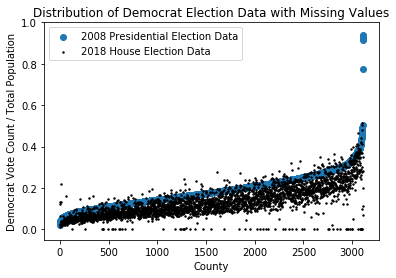

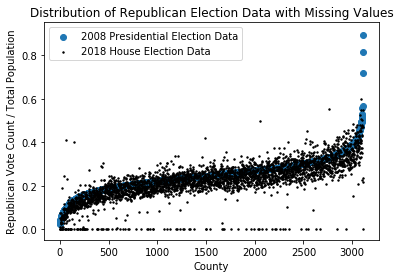

Counties with Missing Democract House Data:  61
Counties with Missing Republican House Data:  96


In [56]:
#### Plot Distribution of Ordered Presidential Party Vote / Total Population ####

import numpy as np
from matplotlib import pyplot as plt

totalPopulationCounty_List = [s.split('(')[0] for s in countyCensusData.iloc[:,3].values]
totalPopulationCounty_Dict = dict(zip(listOfCountyIds, totalPopulationCounty_List))

#Democratic Vote Count
presidentialElectionData_CountyIds = presidentialElectionData.iloc[:,0].values
presidentialElectionData_Dem2008VoteCount = presidentialElectionData.iloc[:,3].values
presidentialElectionData_Dem2008VoteCount_Dict = dict(zip(presidentialElectionData_CountyIds, presidentialElectionData_Dem2008VoteCount))

presidentialElectionData_Dem2008VoteCount_TotalPopulation = {}
for county in presidentialElectionData_CountyIds:
    value = float(presidentialElectionData_Dem2008VoteCount_Dict.get(county))/float(totalPopulationCounty_Dict.get(county))
    presidentialElectionData_Dem2008VoteCount_TotalPopulation.update({county: value})
    
sorted_pED_DVC_TP = sorted(presidentialElectionData_Dem2008VoteCount_TotalPopulation, key=presidentialElectionData_Dem2008VoteCount_TotalPopulation.get)

houseElectionData_CountyIds = houseElectionData.iloc[:,1].values
houseElectionData_DemVoteCount = houseElectionData.iloc[:,3].values
houseElectionData_DemVoteCount_Dict = dict(zip(houseElectionData_CountyIds, houseElectionData_DemVoteCount))

pED_DVC_TP_sorted_HED_DVC_TP = []
for county in sorted_pED_DVC_TP:
    value = float(houseElectionData_DemVoteCount_Dict.get(county, 0))/float(totalPopulationCounty_Dict.get(county))
    pED_DVC_TP_sorted_HED_DVC_TP.append(value)
    
_,pEDvalues = zip(*presidentialElectionData_Dem2008VoteCount_TotalPopulation.items())
plt.scatter(range(len(pEDvalues)),sorted(pEDvalues),label="2008 Presidential Election Data")
plt.scatter(range(len(pED_DVC_TP_sorted_HED_DVC_TP)),pED_DVC_TP_sorted_HED_DVC_TP,c='black',s=2,label="2018 House Election Data")
plt.xlabel("County")
plt.ylabel("Democrat Vote Count / Total Population")
plt.title("Distribution of Democrat Election Data with Missing Values")
plt.legend()
plt.show()

#Republican Vote Count
presidentialElectionData_Rep2008VoteCount = presidentialElectionData.iloc[:,4].values
presidentialElectionData_Rep2008VoteCount_Dict = dict(zip(presidentialElectionData_CountyIds, presidentialElectionData_Rep2008VoteCount))

presidentialElectionData_Rep2008VoteCount_TotalPopulation = {}
for county in presidentialElectionData_CountyIds:
    value = float(presidentialElectionData_Rep2008VoteCount_Dict.get(county))/float(totalPopulationCounty_Dict.get(county))
    presidentialElectionData_Rep2008VoteCount_TotalPopulation.update({county: value})

sorted_pED_RVC_TP = sorted(presidentialElectionData_Rep2008VoteCount_TotalPopulation, key=presidentialElectionData_Rep2008VoteCount_TotalPopulation.get)

houseElectionData_RepVoteCount = houseElectionData.iloc[:,4].values
houseElectionData_RepVoteCount_Dict = dict(zip(houseElectionData_CountyIds, houseElectionData_RepVoteCount))

pED_RVC_TP_sorted_HED_RVC_TP = []
for county in sorted_pED_RVC_TP:
    value = float(houseElectionData_RepVoteCount_Dict.get(county, 0))/float(totalPopulationCounty_Dict.get(county))
    pED_RVC_TP_sorted_HED_RVC_TP.append(value)

_,pEDvalues = zip(*presidentialElectionData_Rep2008VoteCount_TotalPopulation.items())
plt.scatter(range(len(pEDvalues))[:-1],sorted(pEDvalues)[:-1],label="2008 Presidential Election Data")
plt.scatter(range(len(pED_RVC_TP_sorted_HED_RVC_TP)),pED_RVC_TP_sorted_HED_RVC_TP,c='black',s=2,label="2018 House Election Data")
plt.xlabel("County")
plt.ylabel("Republican Vote Count / Total Population")
plt.title("Distribution of Republican Election Data with Missing Values")
plt.legend()
plt.show()

print("Counties with Missing Democract House Data: ",len(filter(lambda x: (x==0),pED_DVC_TP_sorted_HED_DVC_TP)))
print("Counties with Missing Republican House Data: ",len(filter(lambda x: (x==0),pED_RVC_TP_sorted_HED_RVC_TP)))

In [58]:
#### Impute House Party Vote / Total Population Values from Distribution ####

missingHouseDemCounties = [countyDict[sorted_pED_DVC_TP[i]] for i, x in enumerate(pED_DVC_TP_sorted_HED_DVC_TP) if x == 0]
missingHouseRepCounties = [countyDict[sorted_pED_RVC_TP[i]] for i, x in enumerate(pED_RVC_TP_sorted_HED_RVC_TP) if x == 0]
#print(len(missingHouseDemCounties),len(missingHouseRepCounties))
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
missingHouseBothCounties = intersection(missingHouseDemCounties,missingHouseRepCounties)
#print([x for x in missingHouseRepCounties if x not in missingHouseBothCounties])


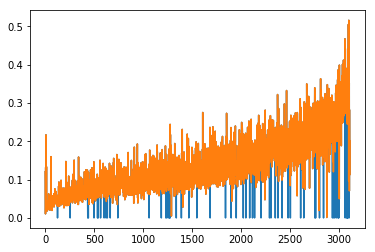

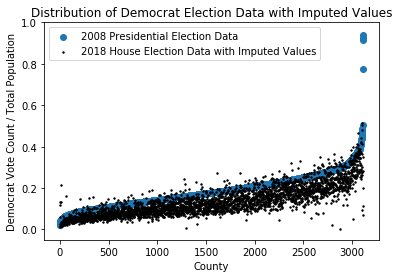

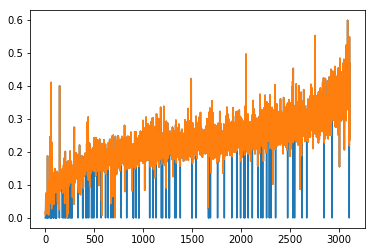

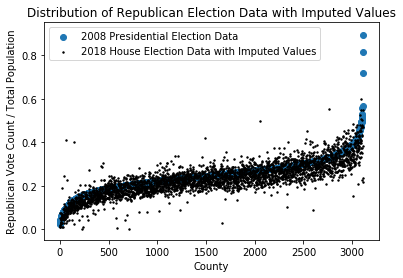

In [192]:
from scipy.ndimage import filters

d=pED_DVC_TP_sorted_HED_DVC_TP
ker = (1.0/8.0)*np.array([1,1,1,1,0,1,1,1,1], dtype=np.float)
out = filters.convolve1d(d, ker)
imputed_HED_DVC_TP = []
for i,x in enumerate(d):
    if x == 0:
        imputed_HED_DVC_TP.append(out[i])
    else:
        imputed_HED_DVC_TP.append(x)
imputed_HED_DVC_TP_Dict = dict(zip(sorted_pED_DVC_TP,imputed_HED_DVC_TP))
plt.plot(d)
plt.plot(imputed_HED_DVC_TP)
plt.show()

_,pEDvalues = zip(*presidentialElectionData_Dem2008VoteCount_TotalPopulation.items())
plt.scatter(range(len(pEDvalues)),sorted(pEDvalues),label="2008 Presidential Election Data")
plt.scatter(range(len(imputed_HED_DVC_TP)),imputed_HED_DVC_TP,c='black',s=2,label="2018 House Election Data with Imputed Values")
plt.xlabel("County")
plt.ylabel("Democrat Vote Count / Total Population")
plt.title("Distribution of Democrat Election Data with Imputed Values")
plt.legend()
plt.show()

d=pED_RVC_TP_sorted_HED_RVC_TP
ker = (1.0/8.0)*np.array([1,1,1,1,0,1,1,1,1], dtype=np.float)
out = filters.convolve1d(d, ker)
imputed_HED_RVC_TP = []
for i,x in enumerate(d):
    if x == 0:
        imputed_HED_RVC_TP.append(out[i])
    else:
        imputed_HED_RVC_TP.append(x)
imputed_HED_RVC_TP_Dict = dict(zip(sorted_pED_RVC_TP,imputed_HED_RVC_TP))
plt.plot(d)
plt.plot(imputed_HED_RVC_TP)
plt.show()

_,pEDvalues = zip(*presidentialElectionData_Rep2008VoteCount_TotalPopulation.items())
plt.scatter(range(len(pEDvalues))[:-1],sorted(pEDvalues)[:-1],label="2008 Presidential Election Data")
plt.scatter(range(len(imputed_HED_RVC_TP)),imputed_HED_RVC_TP,c='black',s=2,label="2018 House Election Data with Imputed Values")
plt.xlabel("County")
plt.ylabel("Republican Vote Count / Total Population")
plt.title("Distribution of Republican Election Data with Imputed Values")
plt.legend()
plt.show()

In [193]:
#### Calculate Missing House Election Vote Counts ####

outputPath = "2018HouseCountyAggregated_NYTScrape_Imputed.csv"
with open(outputPath, mode = 'w') as output:
    writer = csv.writer(output, lineterminator="\n")
    writer.writerow(["fips","county_name","dem_vote_count","rep_vote_count"])
    
    for key in imputed_HED_DVC_TP_Dict.keys():
        writer.writerow([key,countyDict[key],imputed_HED_DVC_TP_Dict[key]*float(totalPopulationCounty_Dict[key]),imputed_HED_RVC_TP_Dict[key]*float(totalPopulationCounty_Dict[key])])

In [194]:
#### Reappend Target Values to Training Data (County Level Census Data Set) ####

AllCountyCensusDataFilePath = "../CensusData/CensusDemographicProfileData2010/CountyLevel/DEC_10_DP_DPDP1/DEC_10_DP_DPDP1_with_ann.csv"
with open(AllCountyCensusDataFilePath) as file:
    reader = csv.reader(file)

    outputPath = "../CensusData/CensusDemographicProfileData2010/CountyLevel/DEC_10_DP_DPDP1/DEC_10_DP_DPDP1_with_2018_house_imputed_election_results.csv"
    with open(outputPath, mode = 'w') as output:
        writer = csv.writer(output, lineterminator="\n")
        row = next(reader, None)
        writer.writerow(row + ["DemVC_TP", "RepVC_TP"])
        row = next(reader, None)
        writer.writerow(row + ["DemVoteCount_TotalPopulation", "RepVoteCount_TotalPopulation"])

        for row in reader:
            cID = int(row[1])
            DemVC_TP = imputed_HED_DVC_TP_Dict.get(cID,None)
            RepVC_TP = imputed_HED_RVC_TP_Dict.get(cID,None)
            if DemVC_TP is not None and RepVC_TP is not None:
                writer.writerow(row + [DemVC_TP, RepVC_TP])
            else:
                print(countyDict[cID])
                

Aleutians East Borough, Alaska
Aleutians West Census Area, Alaska
Anchorage Municipality, Alaska
Bethel Census Area, Alaska
Bristol Bay Borough, Alaska
Denali Borough, Alaska
Dillingham Census Area, Alaska
Fairbanks North Star Borough, Alaska
Haines Borough, Alaska
Hoonah-Angoon Census Area, Alaska
Juneau City and Borough, Alaska
Kenai Peninsula Borough, Alaska
Ketchikan Gateway Borough, Alaska
Kodiak Island Borough, Alaska
Lake and Peninsula Borough, Alaska
Matanuska-Susitna Borough, Alaska
Nome Census Area, Alaska
North Slope Borough, Alaska
Northwest Arctic Borough, Alaska
Petersburg Census Area, Alaska
Prince of Wales-Hyder Census Area, Alaska
Sitka City and Borough, Alaska
Skagway Municipality, Alaska
Southeast Fairbanks Census Area, Alaska
Valdez-Cordova Census Area, Alaska
Wade Hampton Census Area, Alaska
Wrangell City and Borough, Alaska
Yakutat City and Borough, Alaska
Yukon-Koyukuk Census Area, Alaska
Kalawao County, Hawaii
Bedford city, Virginia


In [195]:
################################################################################
#
# Multivariate Linear Regression Model
#
################################################################################

CountyCensusDataFilePath = "../CensusData/CensusDemographicProfileData2010/CountyLevel/DEC_10_DP_DPDP1/DEC_10_DP_DPDP1_with_2018_house_imputed_election_results.csv"
data = pd.read_csv(CountyCensusDataFilePath, skiprows=[1])

dataColumnLabels = {}
CensusMetadataFilePath = "../CensusData/CensusDemographicProfileData2010/CountyLevel/DEC_10_DP_DPDP1/DEC_10_DP_DPDP1_metadata.csv"
with open(CensusMetadataFilePath) as file:
    reader = csv.reader(file)
    for row in reader:
        dataColumnLabels.update({row[0]:row[1]})

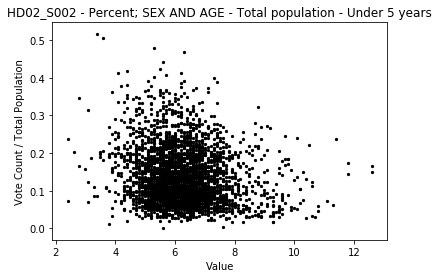

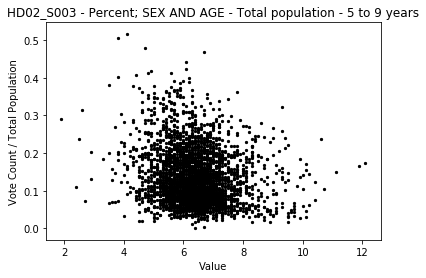

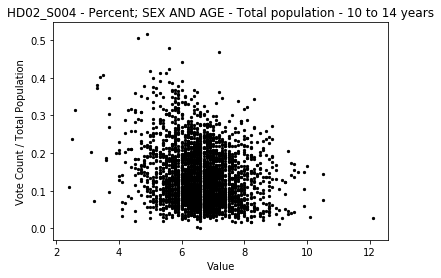

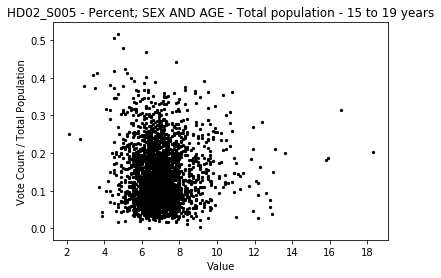

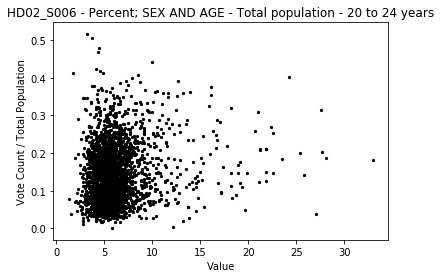

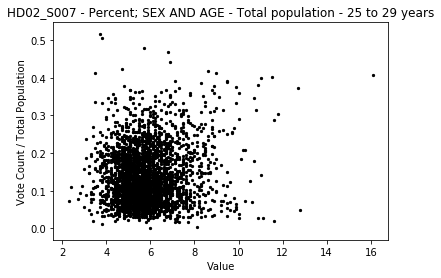

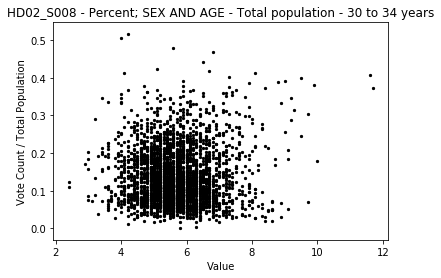

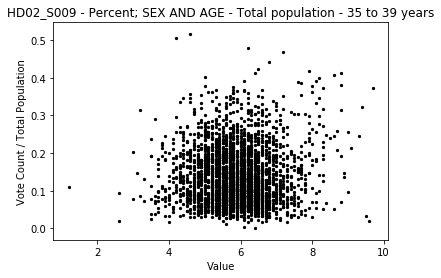

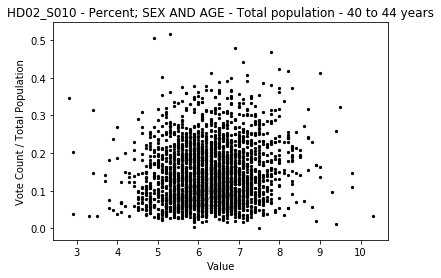

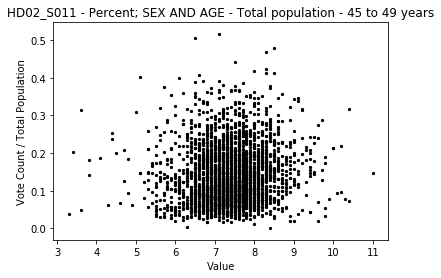

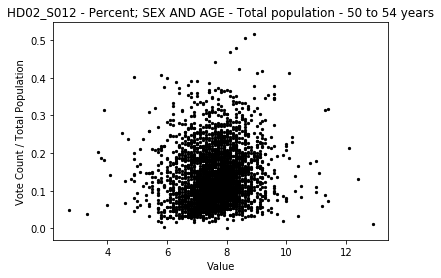

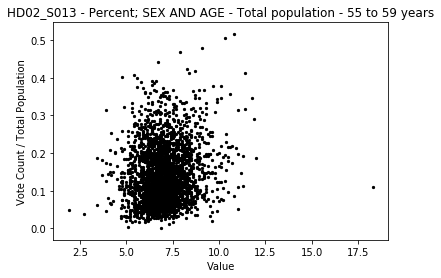

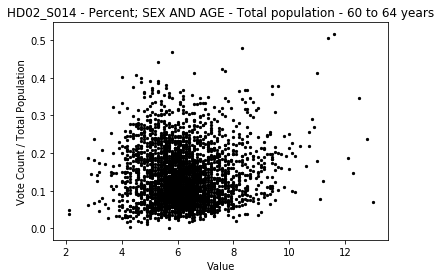

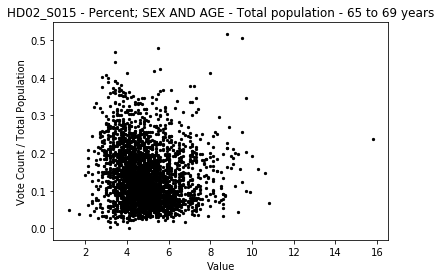

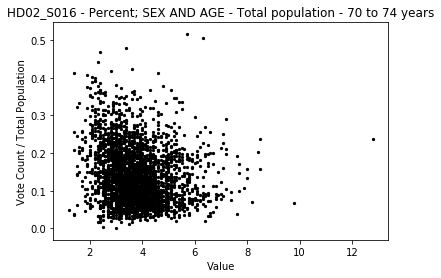

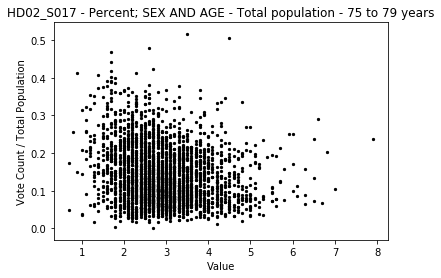

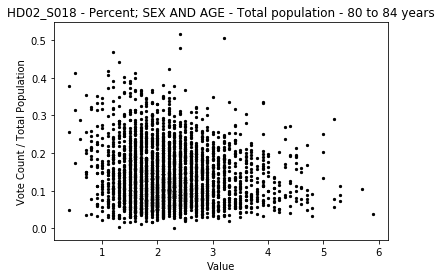

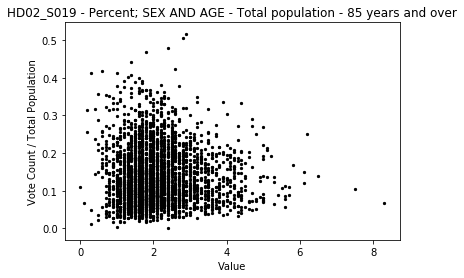

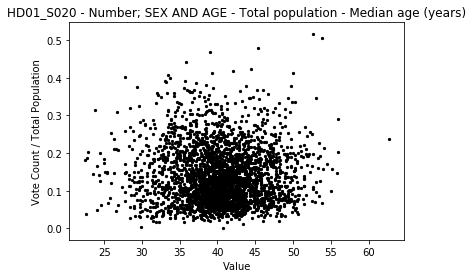

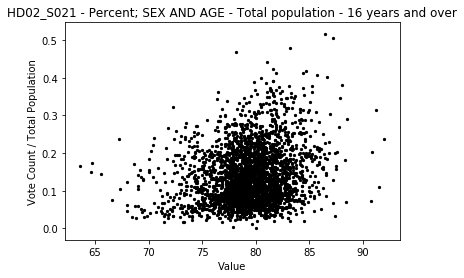

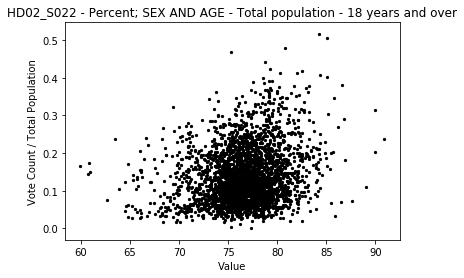

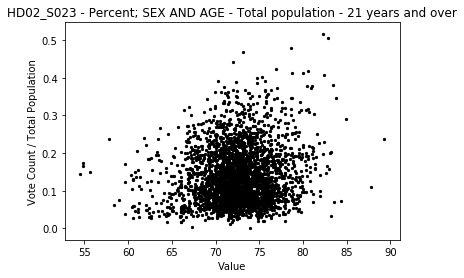

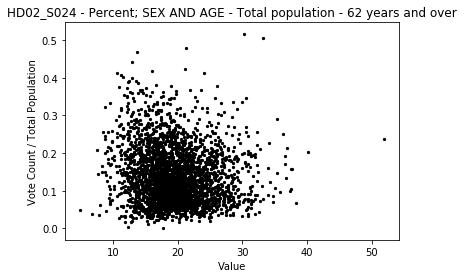

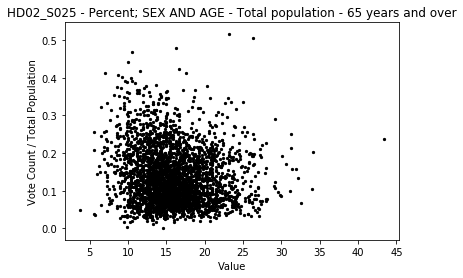

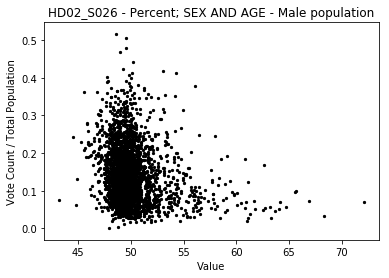

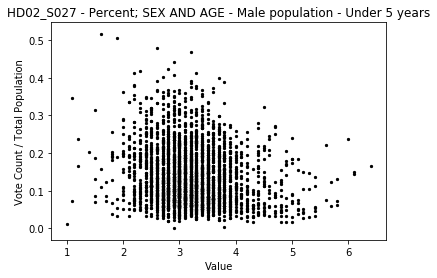

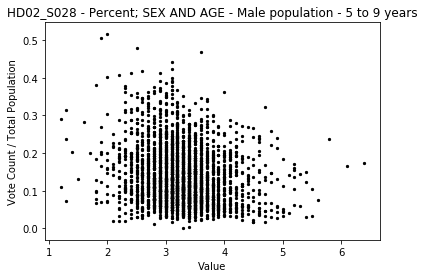

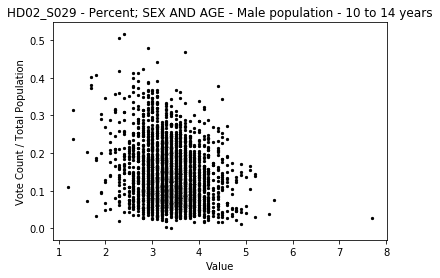

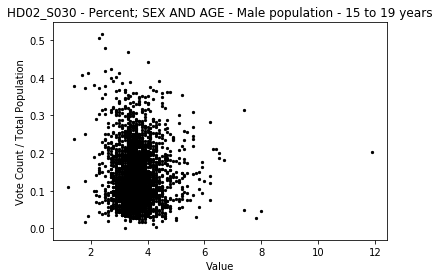

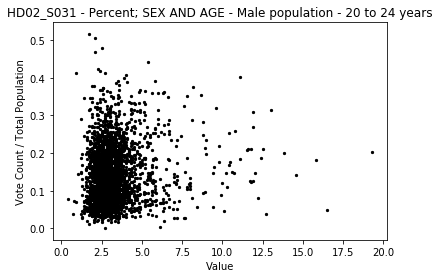

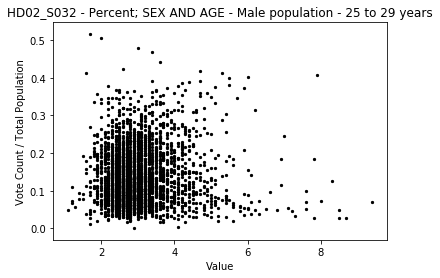

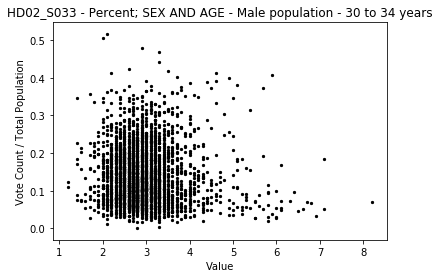

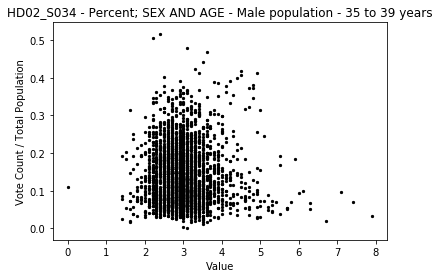

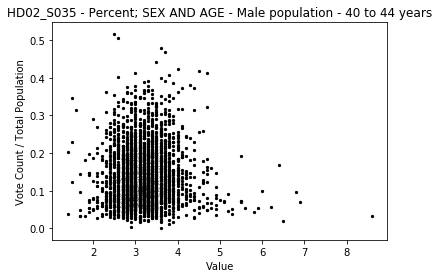

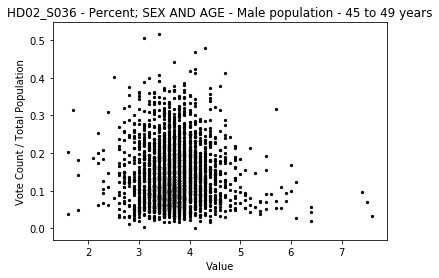

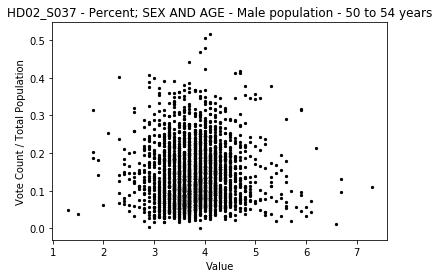

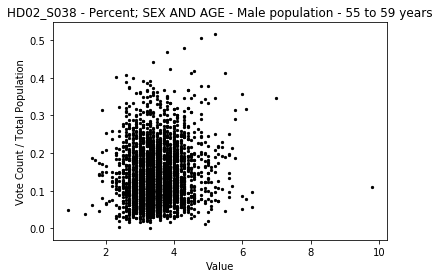

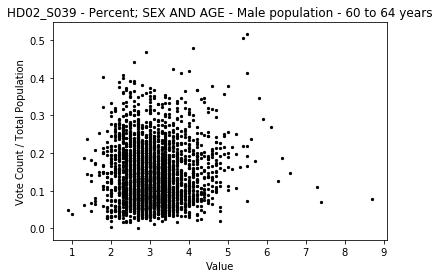

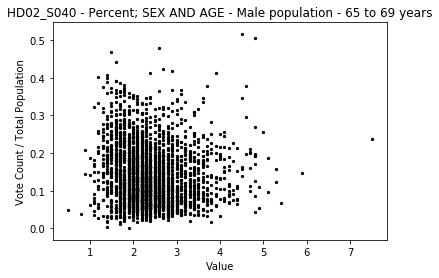

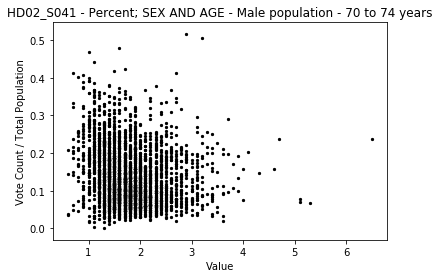

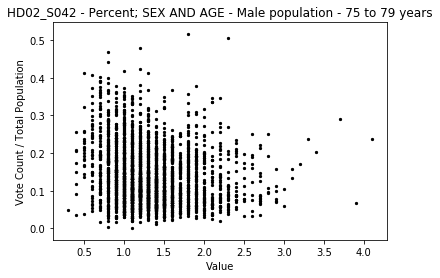

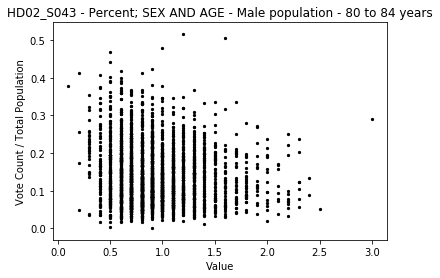

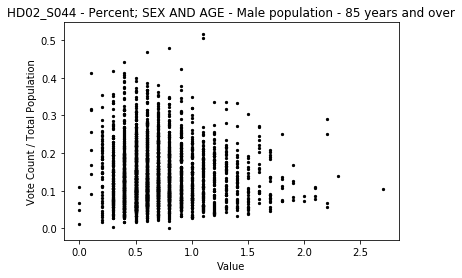

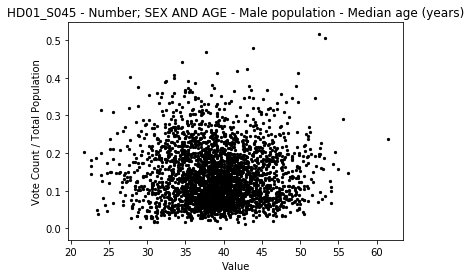

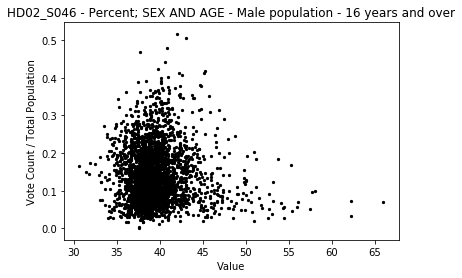

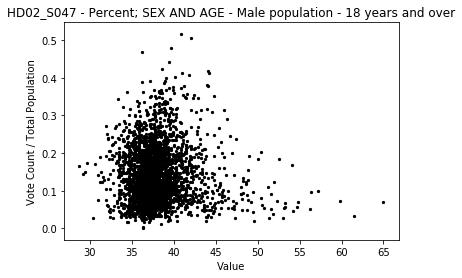

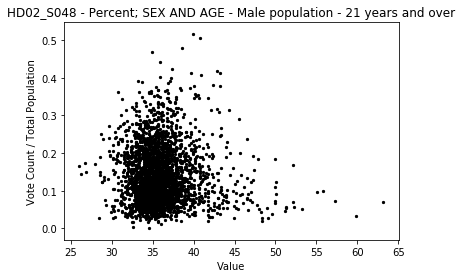

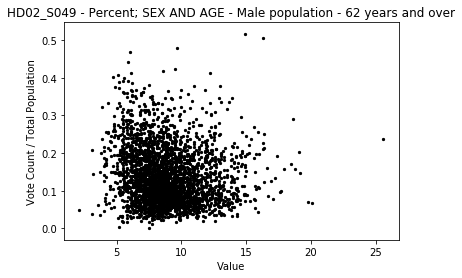

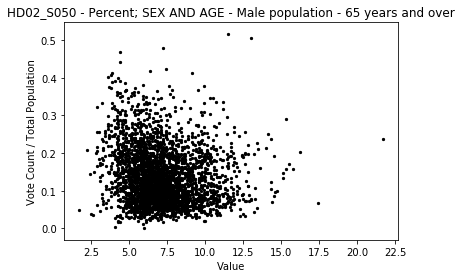

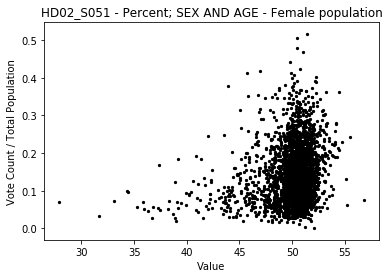

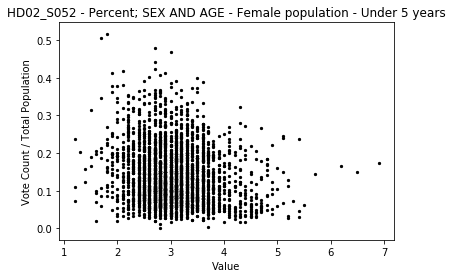

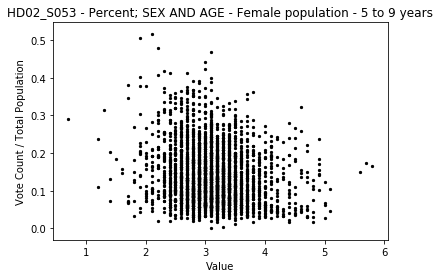

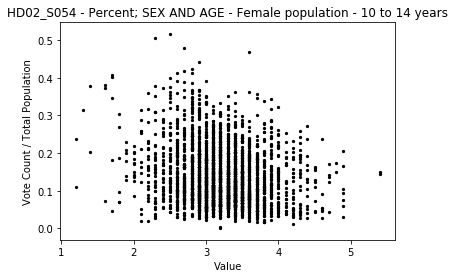

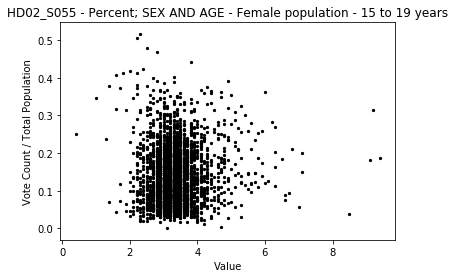

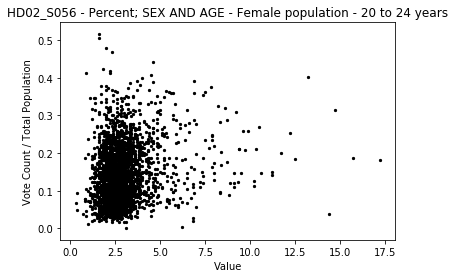

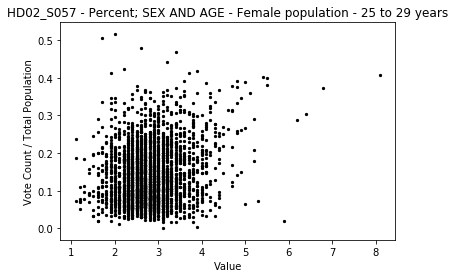

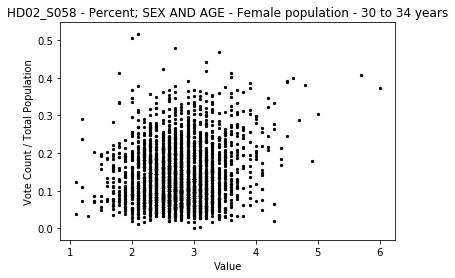

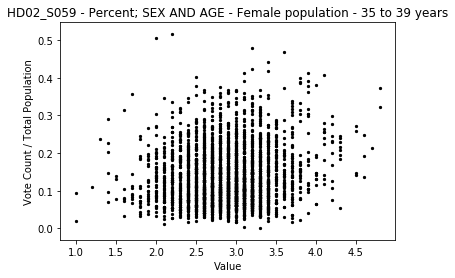

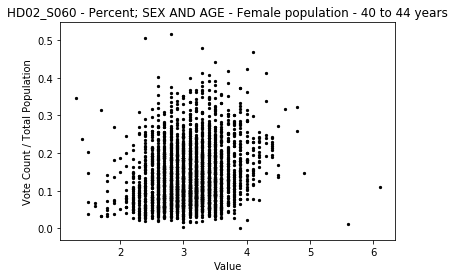

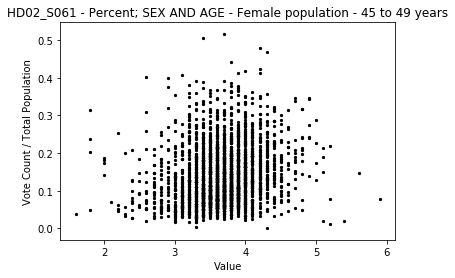

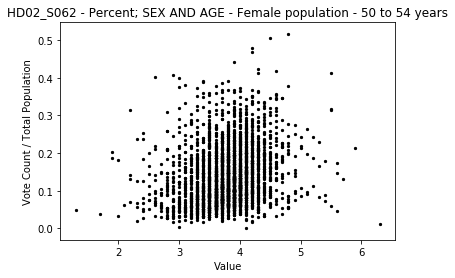

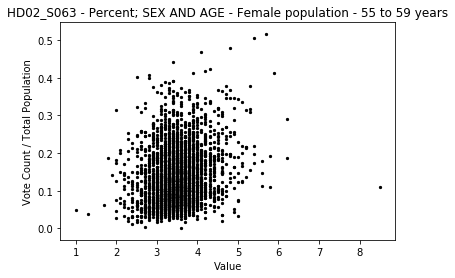

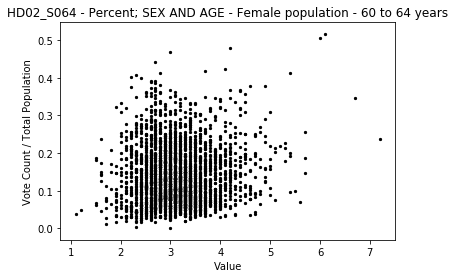

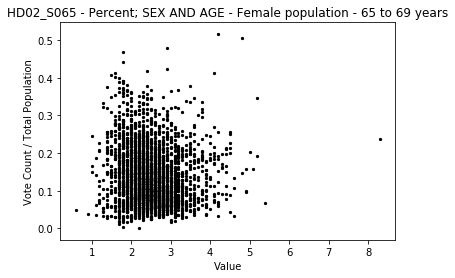

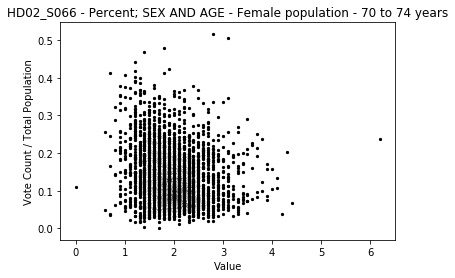

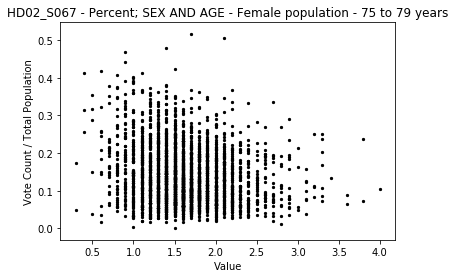

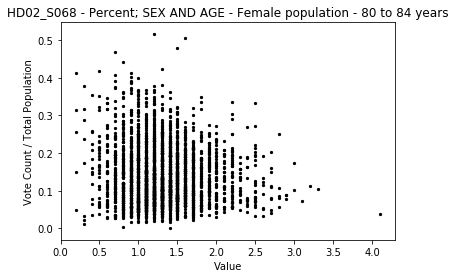

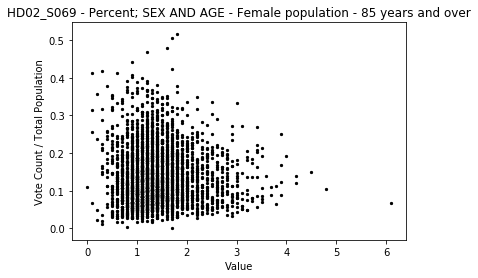

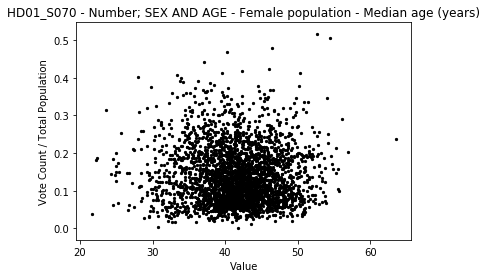

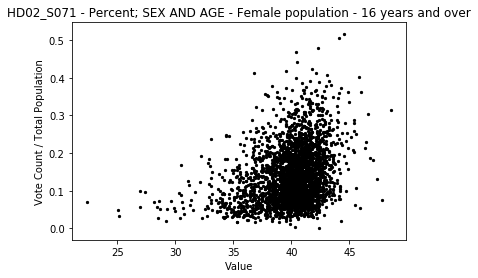

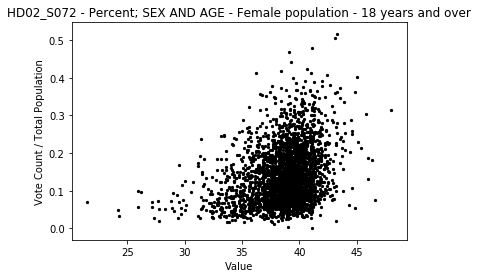

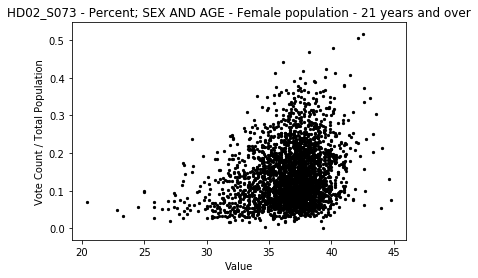

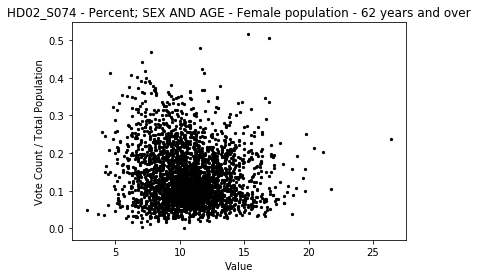

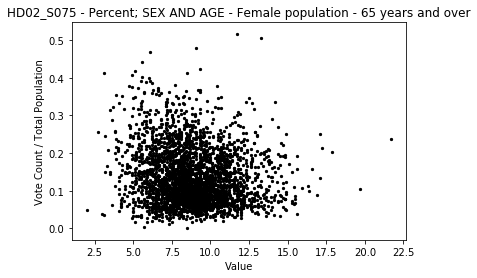

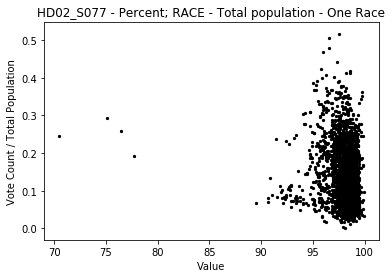

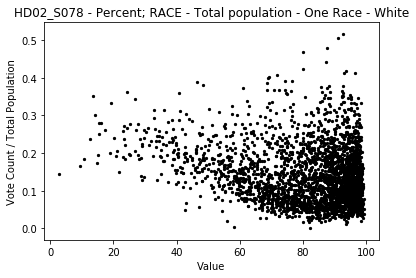

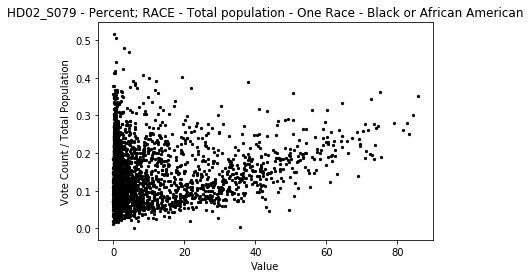

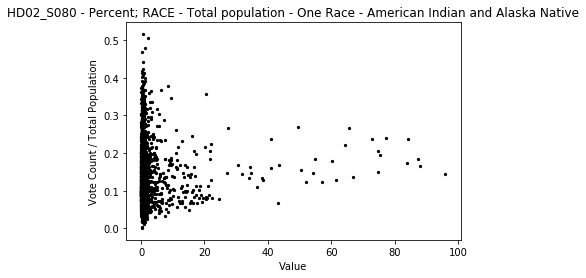

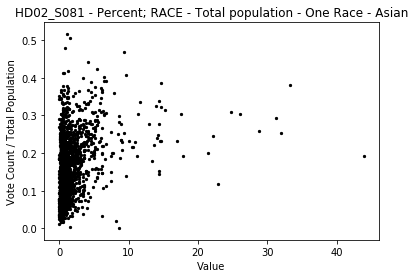

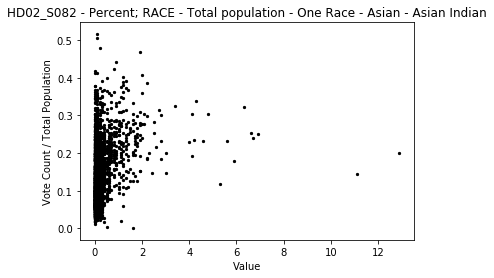

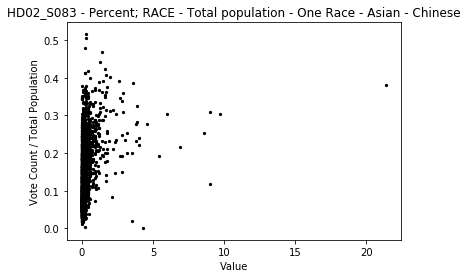

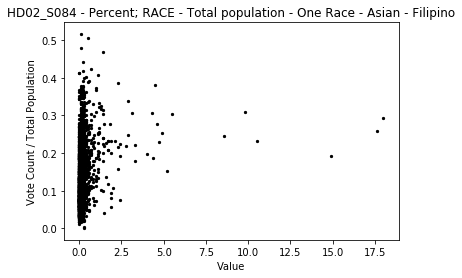

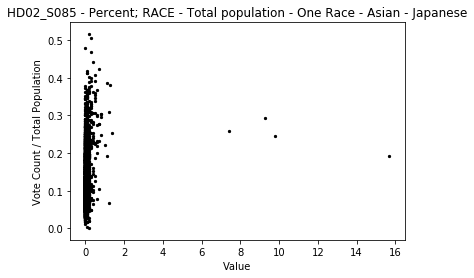

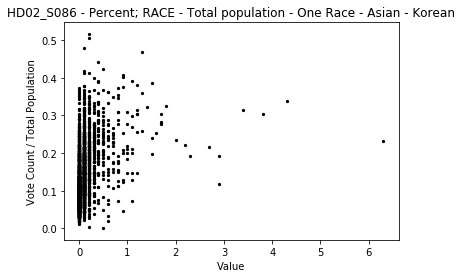

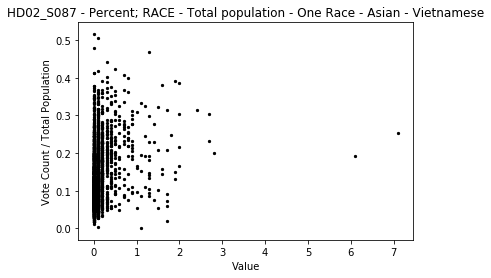

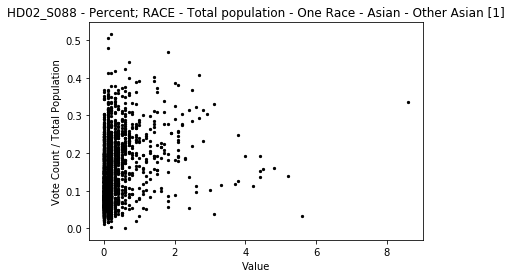

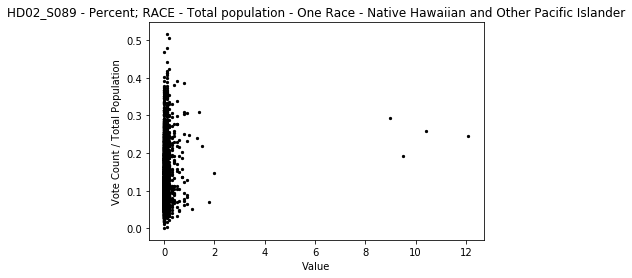

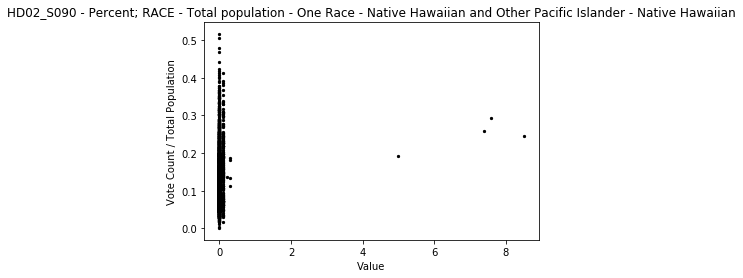

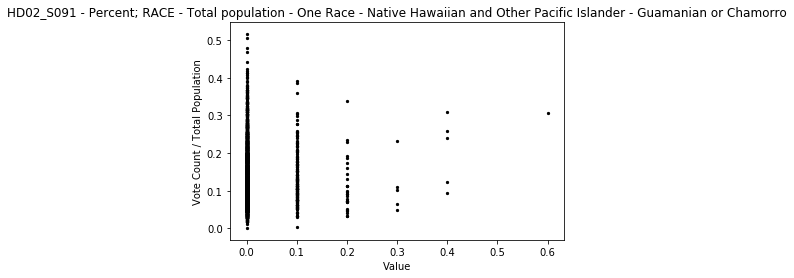

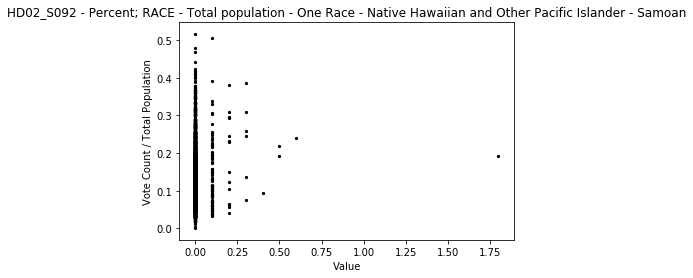

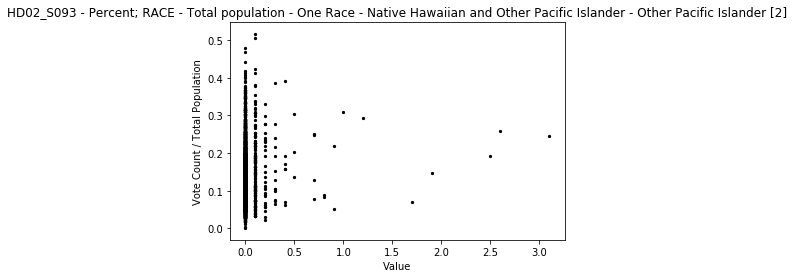

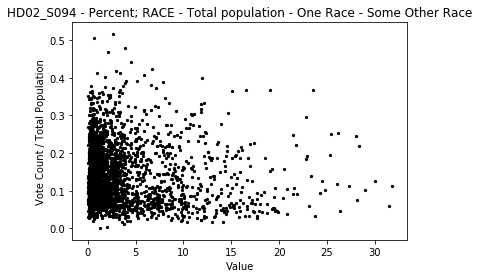

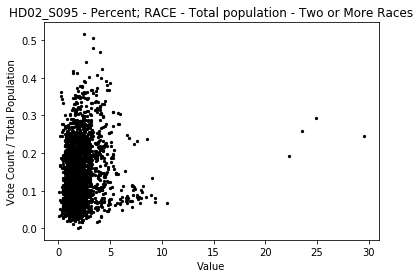

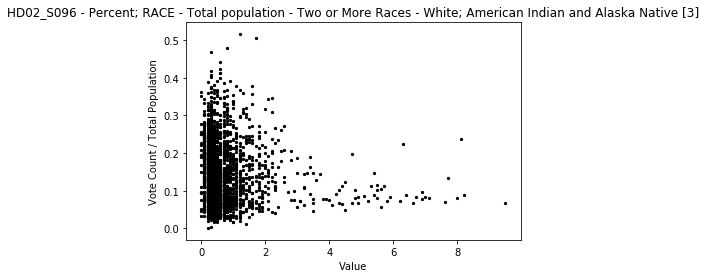

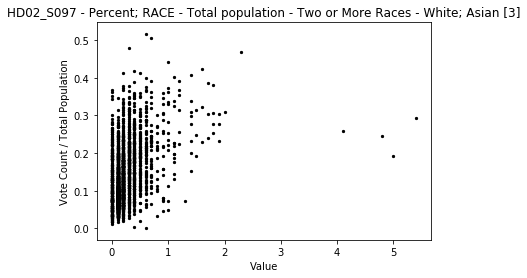

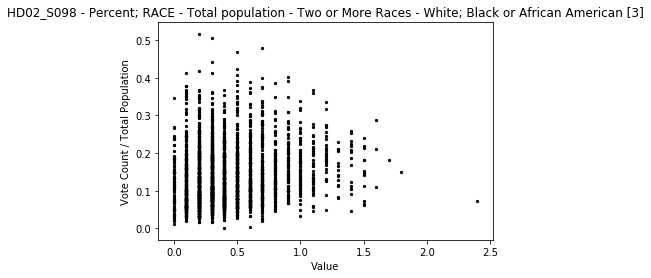

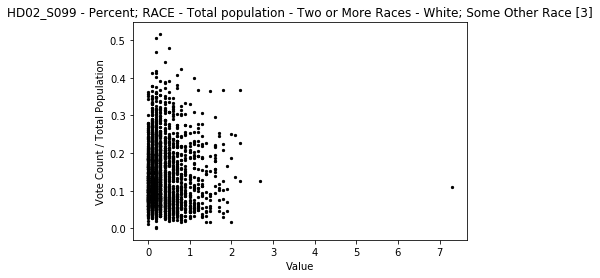

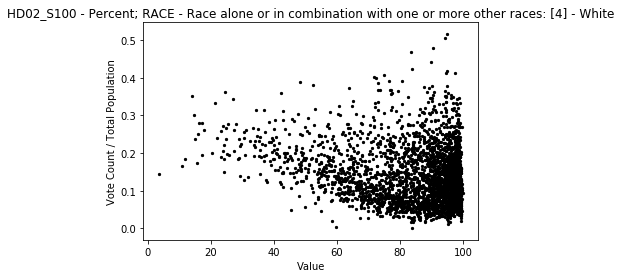

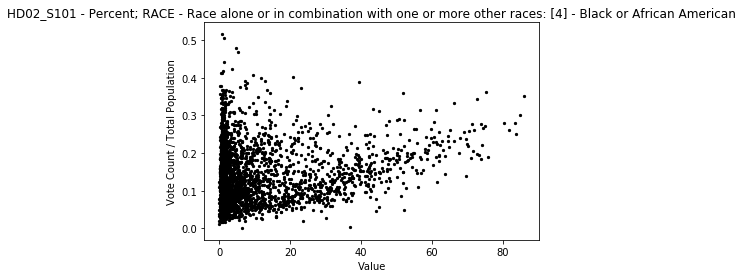

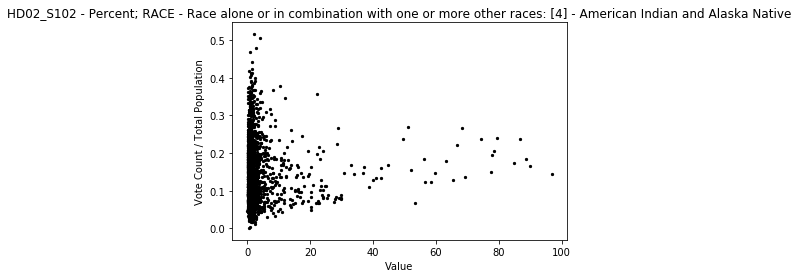

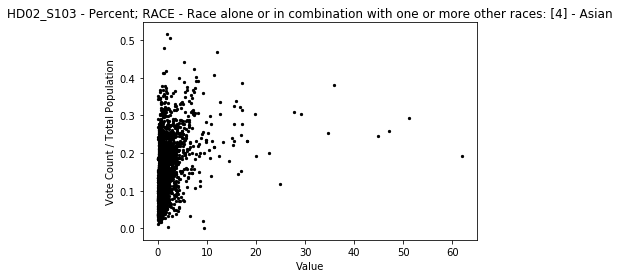

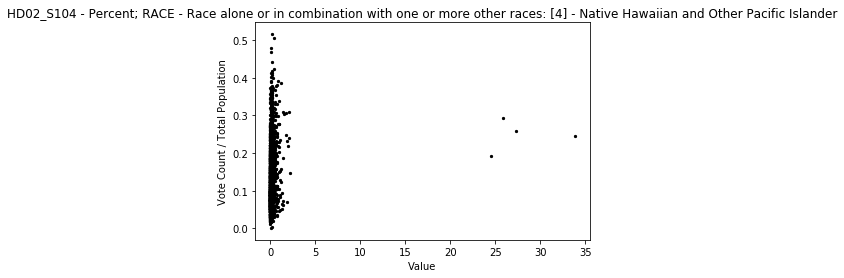

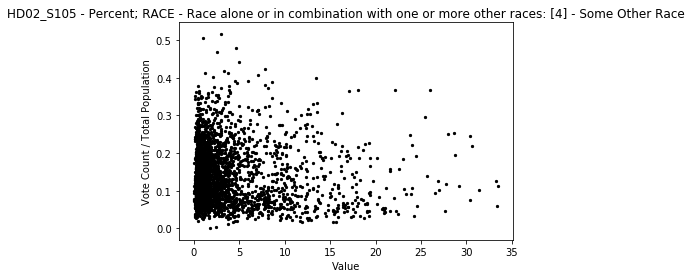

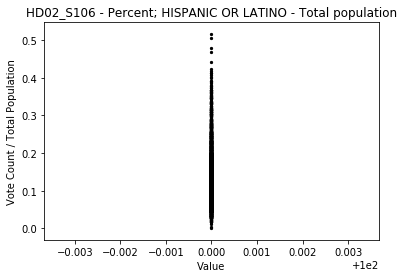

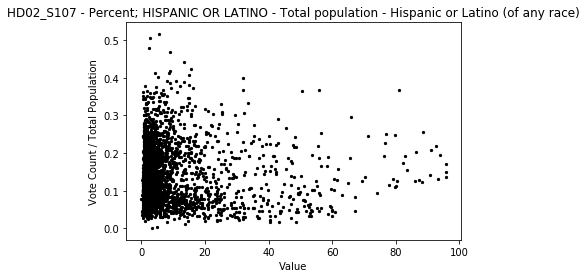

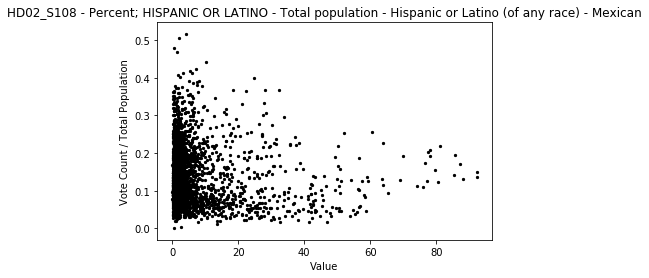

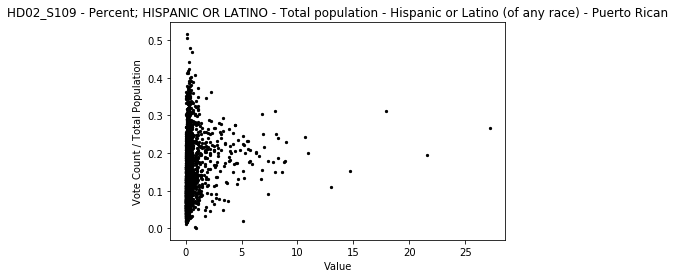

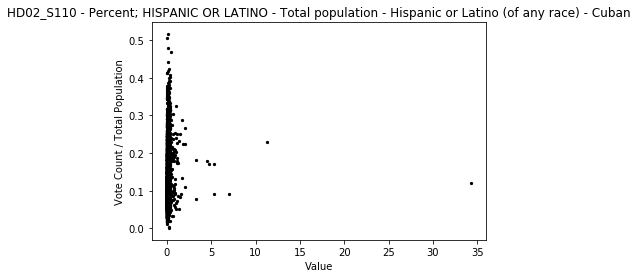

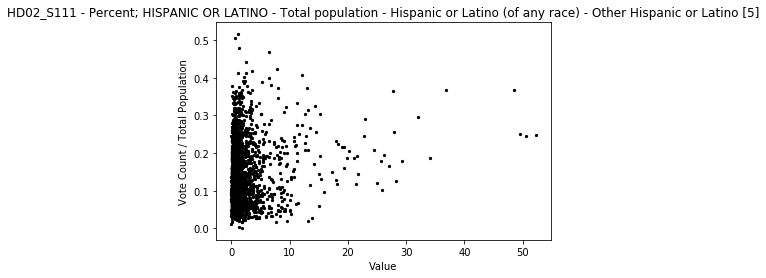

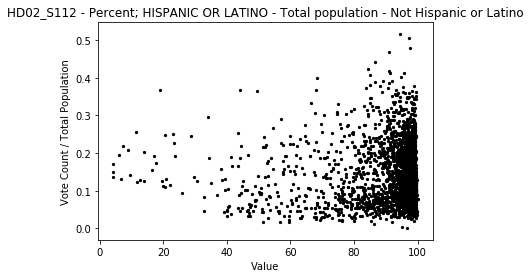

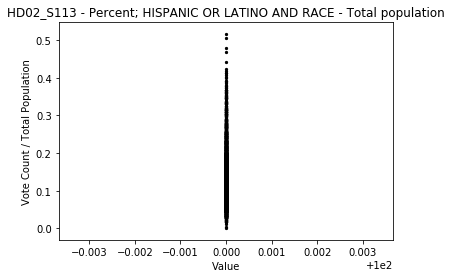

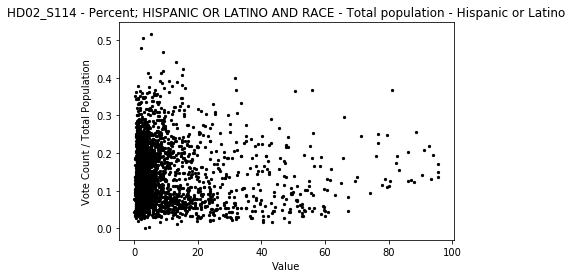

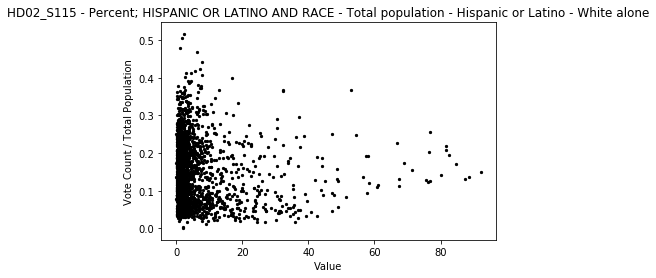

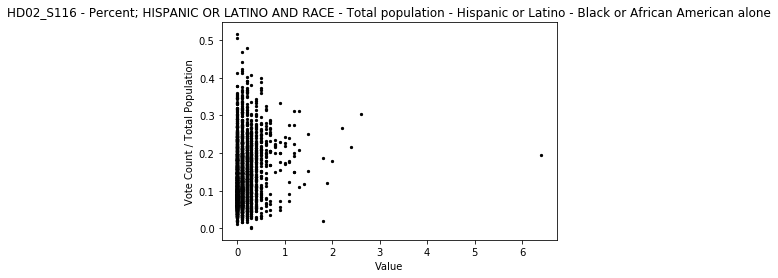

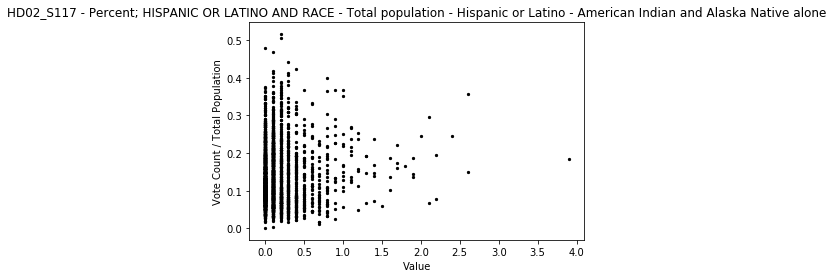

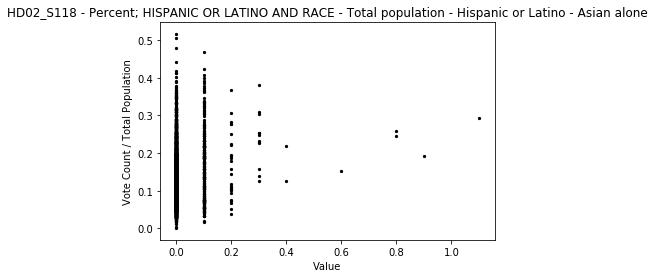

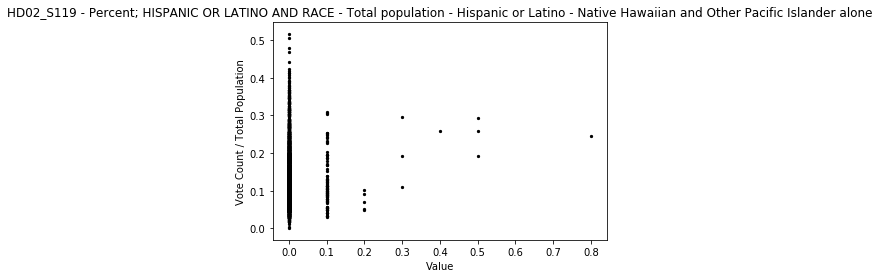

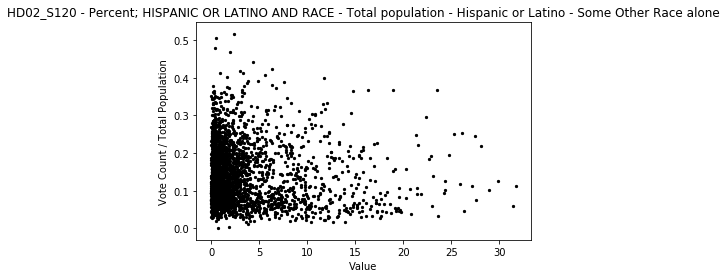

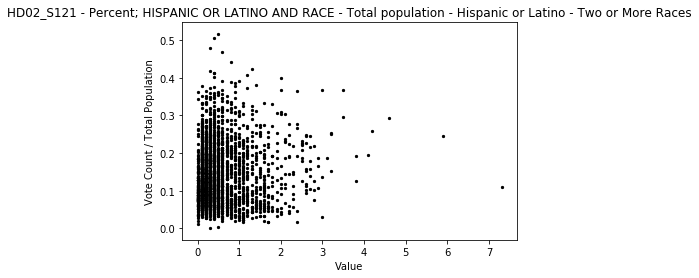

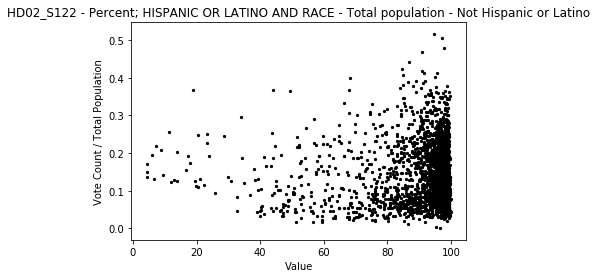

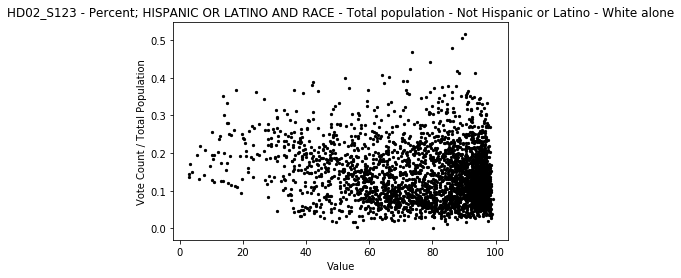

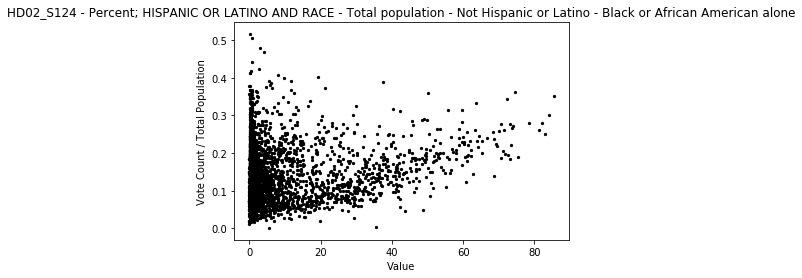

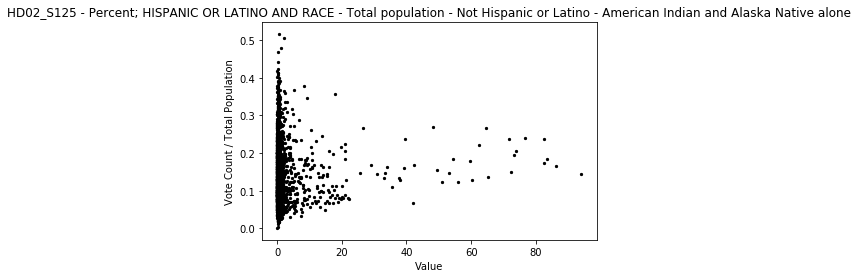

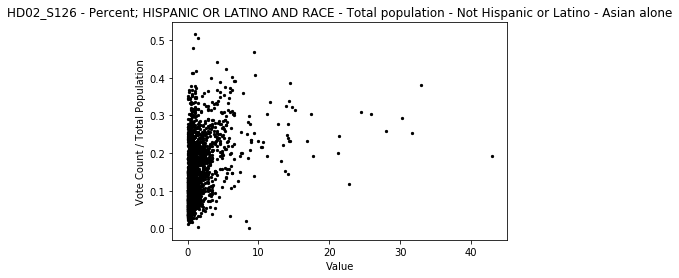

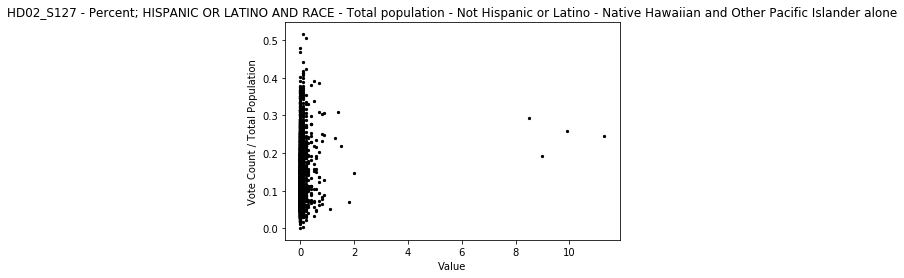

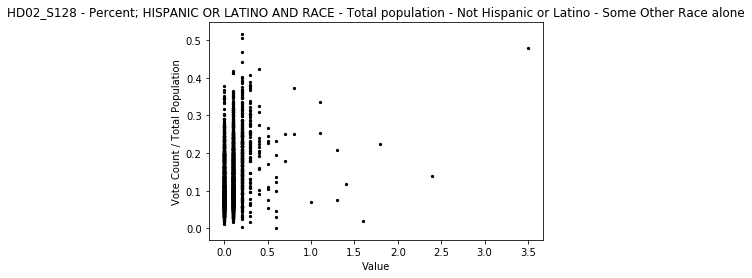

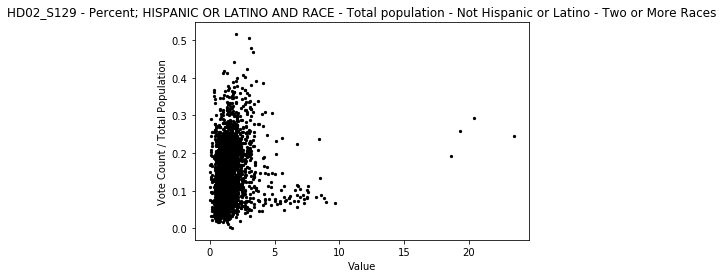

In [196]:
#### Visual Cut of Features from Scatter Plot ####

PotentialLRVariablesFilePath = "PotentialLRVariables"
with open(PotentialLRVariablesFilePath) as file:
    for line in file:
        key = line.rstrip("\n")
        X = data[key].values
        y = data.iloc[:,-2].values
        plt.scatter(X, y, marker='o', s=5, color='black')
        plt.xlabel("Value")
        plt.ylabel("Vote Count / Total Population")
        plt.title(key+" - "+dataColumnLabels[key])
        plt.show()

In [209]:
#### Calculate Correlation Matrix + Heat Map ####

InitialCutLRVariablesFilePath = "InitialCutLRVariables"

correlationMatricies = {}

with open(InitialCutLRVariablesFilePath) as file:
    for line in file:
        key = line.rstrip("\n")
        X = data[key].values
        y = data.iloc[:,-1].values
        
        correlationMatricies.update({key: np.corrcoef(X, y, rowvar=False)})

for d in sorted(correlationMatricies.items(), key=lambda x: abs(x[1][0][1]), reverse=True):
    print(d[0])
    print(dataColumnLabels[d[0]])
    print(d[1][0][1])

HD02_S123
Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - White alone
0.5729632791922186
HD02_S078
Percent; RACE - Total population - One Race - White
0.5411347035681564
HD01_S045
Number; SEX AND AGE - Male population - Median age (years)
0.5409403375257056
HD02_S100
Percent; RACE - Race alone or in combination with one or more other races: [4] - White
0.5319541824938738
HD02_S049
Percent; SEX AND AGE - Male population - 62 years and over
0.5311414798081748
HD02_S050
Percent; SEX AND AGE - Male population - 65 years and over
0.5269336442132784
HD02_S007
Percent; SEX AND AGE - Total population - 25 to 29 years
-0.5149592907551401
HD02_S057
Percent; SEX AND AGE - Female population - 25 to 29 years
-0.4923298225276979
HD02_S024
Percent; SEX AND AGE - Total population - 62 years and over
0.4903197489588836
HD02_S016
Percent; SEX AND AGE - Total population - 70 to 74 years
0.48708864830170095
HD02_S025
Percent; SEX AND AGE - Total population - 65 years and

In [198]:
UpdatedLRVariables = []

LRVariablesFilePath = "LRVariables"
with open(LRVariablesFilePath) as file:
    for line in file:
        key = line.rstrip("\n")
        UpdatedLRVariables.append(key)
        print(key,dataColumnLabels[key])

HD02_S016 Percent; SEX AND AGE - Total population - 70 to 74 years
HD02_S057 Percent; SEX AND AGE - Female population - 25 to 29 years
HD02_S078 Percent; RACE - Total population - One Race - White
HD02_S079 Percent; RACE - Total population - One Race - Black or African American
HD02_S081 Percent; RACE - Total population - One Race - Asian


In [199]:
#### K-Fold Cross Validation -> Average RMSE ####

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = data[UpdatedLRVariables].values
y = data.iloc[:,-2].values

lr_models = []
all_rmse = []

i = 0
kfold = KFold(10, shuffle=True)
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    model = sm.OLS(y_train, X_train).fit()
    #print(model.summary())
    lr_models.append(model)

    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    all_rmse.append(rmse)

print(np.mean(all_rmse))

0.06834780449717755


1.2196189337121297


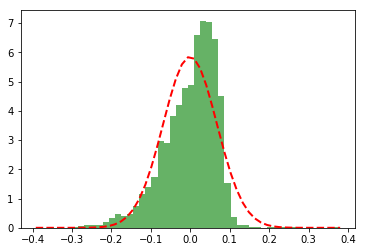

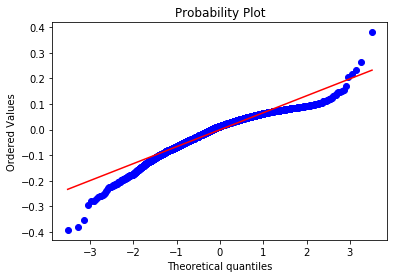

[[ 1.         -0.67660641  0.32818484 -0.19659292 -0.31894467]
 [-0.67660641  1.         -0.3997078   0.27169574  0.36815857]
 [ 0.32818484 -0.3997078   1.         -0.82765461 -0.26496303]
 [-0.19659292  0.27169574 -0.82765461  1.          0.03029221]
 [-0.31894467  0.36815857 -0.26496303  0.03029221  1.        ]]
158.3440028980405


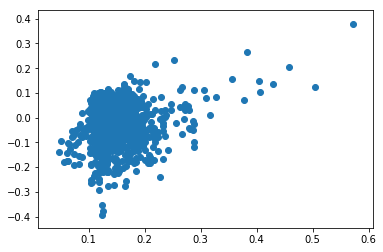

In [202]:
#### Check Assumptions for Multivariate Linear Regression ####

X = data[UpdatedLRVariables].values
y = data.iloc[:,-2].values

train, test = train_test_split(data, test_size=0.2)

X_train = train[UpdatedLRVariables].values
y_train = train.iloc[:,-2].values
X_test = test[UpdatedLRVariables].values
y_test = test.iloc[:,-2].values

#model = sm.OLS(y_train, X_train).fit()
#y_pred = model.predict(X_test)
#residuals = y_pred - y_test

model = sm.OLS(y, X).fit()
y_pred = model.predict(X)
residuals = y_pred - y

#Independence of Observations - Durbin-Watson Statistic
from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(residuals))

#Residuals are Approximately Normally Distributed - Histogram with Superimposed Normal Curve
from scipy.stats import norm
mu, sigma = norm.fit(residuals)
n, bins, patches = plt.hist(residuals, bins=50, density=True, alpha=0.6, color='g')
y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)

plt.show()

#Normal P-P Plot
from scipy import stats
stats.probplot(residuals, plot=plt)
plt.show()

#No Multicollinearity - Variance Inflation Factor higher than 10 or 
#Correlation Matrix with Magnitude of Correlation Coefficients greater that .80 
#-> Center Data by Subtracting Mean Score from Each Observation for Each Independent Variable
print(np.corrcoef(X, rowvar=False))

print(np.linalg.cond(model.model.exog))

#Homoscedasticity
plt.scatter(y_pred, residuals)
plt.show()

In [96]:
#### Take Subsets of Variables and Perform Nested CV ####
import itertools

for i in range(len(UpdatedLRVariables)):
    for key_set in list(itertools.combinations(UpdatedLRVariables, i+1)):
        #print(list(key_set))
        
        X = data[list(key_set)].values
        y = data.iloc[:,-2].values

        all_rmse = []
        
        i = 0
        kfold = KFold(10, shuffle=True)
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index] 
            y_train, y_test = y[train_index], y[test_index]
            
            model = sm.OLS(y_train, X_train).fit()
            y_pred = model.predict(X_test)
            rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
            all_rmse.append(rmse)
        print(str(list(key_set)) + " " + str(np.average(all_rmse)))

['HD02_S016'] 0.08757425766489159
['HD02_S057'] 0.07368543718393203
['HD02_S078'] 0.0838630189545351
['HD02_S079'] 0.1315334597255658
['HD02_S081'] 0.13297023572964936
['HD02_S016', 'HD02_S057'] 0.07297826400989274
['HD02_S016', 'HD02_S078'] 0.08351597100131572
['HD02_S016', 'HD02_S079'] 0.083192883472792
['HD02_S016', 'HD02_S081'] 0.07762339195792053
['HD02_S057', 'HD02_S078'] 0.0735372207080928
['HD02_S057', 'HD02_S079'] 0.07324663532431434
['HD02_S057', 'HD02_S081'] 0.07175242246784852
['HD02_S078', 'HD02_S079'] 0.07542759432309151
['HD02_S078', 'HD02_S081'] 0.07613545979156887
['HD02_S079', 'HD02_S081'] 0.11523835407540221
['HD02_S016', 'HD02_S057', 'HD02_S078'] 0.07286705249000265
['HD02_S016', 'HD02_S057', 'HD02_S079'] 0.07239334327752753
['HD02_S016', 'HD02_S057', 'HD02_S081'] 0.06990847561215
['HD02_S016', 'HD02_S078', 'HD02_S079'] 0.07517585301104909
['HD02_S016', 'HD02_S078', 'HD02_S081'] 0.07526647066854478
['HD02_S016', 'HD02_S079', 'HD02_S081'] 0.07387383874174551
['HD02_S

In [208]:
#### Predict Party Vote / Total Population for Census Tracts ####

X = data[UpdatedLRVariables].values
yD = data.iloc[:,-2].values
yR = data.iloc[:,-1].values

D_model = sm.OLS(yD, X).fit()
print(D_model.summary())
print(math.sqrt(D_model.scale))
R_model = sm.OLS(yR, X).fit()
print(R_model.summary())
print(math.sqrt(R_model.scale))

TractPredictions = {}
TractPopulation = {}

StateAbbrFile = "StateAbbreviations"
with open(StateAbbrFile) as file:
    for line in file:
        state = line.rstrip("\n")
        
        TractCensusDataFilePath = "../CensusData/CensusDemographicProfileData2010/CensusTractLevel/"+state+"_DEC_10_DP_DPDP1/DEC_10_DP_DPDP1_with_ann.csv"
        tract_data = pd.read_csv(TractCensusDataFilePath, skiprows=[1], na_values=["(X)"])
        tract_IDs = tract_data.iloc[:,1].values
        tract_Population = [float(str(s).split('(')[0]) for s in tract_data.iloc[:,3].values]
        tract_X = np.array(tract_data[UpdatedLRVariables].values, dtype=np.float32)
        #print(tract_X)
        tract_D_Predict = D_model.predict(tract_X)
        tract_R_Predict = R_model.predict(tract_X)
        
        for i,tID in enumerate(tract_IDs):
            tDPi = max(0, min(tract_D_Predict[i], 1))
            tRPi = max(0, min(tract_R_Predict[i], 1))
            
            TractPredictions.update({tID:(tDPi,tRPi)})
            TractPopulation.update({tID:tract_Population[i]})

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     2625.
Date:                Thu, 02 May 2019   Prob (F-statistic):               0.00
Time:                        12:14:57   Log-Likelihood:                 3939.4
No. Observations:                3112   AIC:                            -7869.
Df Residuals:                    3107   BIC:                            -7839.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0016      0.001      1.159      0.2

KeyboardInterrupt: 

[55861533.34114474, 55105129.75074907] 0
[58974528.97284102, 51129803.00041075]
169.22091822726685


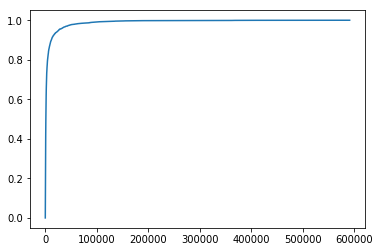

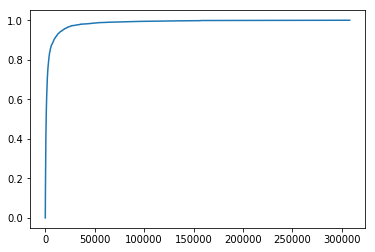

In [101]:
#### Check Sum of Census Tract Predictions Equal County Level Values ####
#### TODO: Further Analysis and Investigation

totalTractDRVC = [0,0]
c = 0
for tID in TractPopulation.keys():
    if not np.isnan(TractPredictions[tID][0]) and not np.isnan(TractPredictions[tID][1]):
        totalTractDRVC[0] += TractPredictions[tID][0] * TractPopulation[tID]
        totalTractDRVC[1] += TractPredictions[tID][1] * TractPopulation[tID]
    else:
        c += 1
print(totalTractDRVC, c)

totalCountyDRVC = [0,0]
for cID in imputed_HED_DVC_TP_Dict.keys():
    totalCountyDRVC[0] += imputed_HED_DVC_TP_Dict[cID]*float(totalPopulationCounty_Dict[cID])
    totalCountyDRVC[1] += imputed_HED_RVC_TP_Dict[cID]*float(totalPopulationCounty_Dict[cID])
print(totalCountyDRVC)

TractDistrictSplitFilePath = "../QGIS/tract_district_splits.csv"
County_Tracts = {}
CountyDistrict_Tracts = {}
with open(TractDistrictSplitFilePath) as file:
    reader = csv.reader(file)
    next(reader, None)
    for row in reader:
        if row[2] == 'current':
            cID = int(row[3])
            tID = int(row[4])
            district = int(row[5])
            percentage = float(row[6])
            
            if County_Tracts.has_key(cID):
                TractList = County_Tracts[cID]
                TractList.append((tID, percentage))
                County_Tracts[cID] = TractList
            else:
                County_Tracts.update({cID:[(tID, percentage)]})
                
            if CountyDistrict_Tracts.has_key((cID, district)):
                TractList = CountyDistrict_Tracts[(cID, district)]
                TractList.append((tID, percentage))
                CountyDistrict_Tracts[(cID, district)] = TractList
            else:
                CountyDistrict_Tracts.update({(cID, district):[(tID, percentage)]})

c_pop_resid = []
for cID in County_Tracts.keys():
    t_C = float(totalPopulationCounty_Dict[cID])

    t_T = 0
    TractList = County_Tracts[cID]
    for tract in TractList:
        tID = tract[0]
        percentage = tract[1]
        t_T += TractPopulation.get(tID, 0) * percentage
    #print(cID, t_C, t_T)
    c_pop_resid.append(abs(t_C - t_T))
print(np.mean(c_pop_resid))

dvc_resid = {}
rvc_resid = {}
#73,057 Census Tracts - 2010 Census National Geographic Tallies
#c = 0
for cID in County_Tracts.keys():
    d_C = imputed_HED_DVC_TP_Dict.get(cID,0)*float(totalPopulationCounty_Dict.get(cID,0))
    r_C = imputed_HED_RVC_TP_Dict.get(cID,0)*float(totalPopulationCounty_Dict.get(cID,0))

    d_T = 0
    r_T = 0
    TractList = County_Tracts[cID]
    for tract in TractList:
        #c += 1
        tID = tract[0]
        percentage = tract[1]
        if not np.isnan(TractPredictions.get(tID,(0,0))[0]):
            d_T += TractPredictions.get(tID,(0,0))[0] * TractPopulation.get(tID, 0) * percentage
        if not np.isnan(TractPredictions.get(tID,(0,0))[1]):
            r_T += TractPredictions.get(tID,(0,0))[1] * TractPopulation.get(tID, 0) * percentage
    #print(cID, d_C, d_T)
    #print(cID, r_C, r_T)
    dvc_resid.update({cID:abs(d_C - d_T)})
    rvc_resid.update({cID:abs(r_C - r_T)})
sorted_dvc_resid = sorted(dvc_resid, key=dvc_resid.get, reverse = True)
sorted_rvc_resid = sorted(rvc_resid, key=rvc_resid.get, reverse = True)
#for i in range(100):
    #cID = sorted_dvc_resid[i]
    #print(countyDict[cID], cID, dvc_resid[cID], float(totalPopulationCounty_Dict[cID]))
    #cID = sorted_rvc_resid[i]
    #print(countyDict[cID], cID, rvc_resid[cID], float(totalPopulationCounty_Dict[cID]))
#print(c)

sorted_data = sorted(dvc_resid.values())
yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)
plt.plot(sorted_data,yvals)
plt.show()
sorted_data = sorted(rvc_resid.values())
yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)
plt.plot(sorted_data,yvals)
plt.show()

In [102]:
#### Generate County Split Values from Hard Prediction ####

outputPath = "../CensusData/CensusDemographicProfileData2010/county_splits_values_house_2018_imputed_w_president_2008.csv"
with open(outputPath, mode = 'w') as output:
    writer = csv.writer(output, lineterminator="\n")
    writer.writerow(["stateFP", "state", "maptype", "countyFP", "county", "district", "dem_CountySplitValue", "rep_CountySplitValue"])
    
    MAPTYPE = ["current","Compact","Dem","GOP","Proportional"]
    
    for maptype in MAPTYPE:
        print("Generating County Split Values for Maptype: ", maptype)
        
        TractDistrictSplitFilePath = "../QGIS/tract_district_splits.csv"
        County_Tracts = {}
        CountyDistrict_Tracts = {}
        with open(TractDistrictSplitFilePath) as file:
            reader = csv.reader(file)
            next(reader, None)
            for row in reader:
                if row[2] == maptype:
                    cID = int(row[3])
                    tID = int(row[4])
                    district = int(row[5])
                    percentage = float(row[6])
                    
                    if County_Tracts.has_key(cID):
                        TractList = County_Tracts[cID]
                        TractList.append((tID, percentage))
                        County_Tracts[cID] = TractList
                    else:
                        County_Tracts.update({cID:[(tID, percentage)]})
                        
                    if CountyDistrict_Tracts.has_key((cID, district)):
                        TractList = CountyDistrict_Tracts[(cID, district)]
                        TractList.append((tID, percentage))
                        CountyDistrict_Tracts[(cID, district)] = TractList
                    else:
                        CountyDistrict_Tracts.update({(cID, district):[(tID, percentage)]})
    
        for key in CountyDistrict_Tracts.keys():
            countyFP = key[0]
            district = key[1]
            CountyDistrict_TractList = CountyDistrict_Tracts[key]
            County_TractList = County_Tracts[countyFP]
            
            demCountyDistrictSum = 0
            repCountyDistrictSum = 0
            for tract in CountyDistrict_TractList:
                tID = tract[0]
                percentage = tract[1]
                
                if not np.isnan(TractPredictions.get(tID,(0,0))[0]) and not np.isnan(TractPredictions.get(tID,(0,0))[1]):
                    demCountyDistrictSum += TractPredictions.get(tID,(0,0))[0] * TractPopulation.get(tID, 0) * percentage
                    repCountyDistrictSum += TractPredictions.get(tID,(0,0))[1] * TractPopulation.get(tID, 0) * percentage
            
            demCountySum = 0
            repCountySum = 0
            for tract in County_TractList:
                tID = tract[0]
                percentage = tract[1]
                
                if not np.isnan(TractPredictions.get(tID,(0,0))[0]) and not np.isnan(TractPredictions.get(tID,(0,0))[1]):
                    demCountySum += TractPredictions.get(tID,(0,0))[0] * TractPopulation.get(tID, 0) * percentage
                    repCountySum += TractPredictions.get(tID,(0,0))[1] * TractPopulation.get(tID, 0) * percentage
            
            if demCountySum != 0:
                dem_CountySplitValue = float(demCountyDistrictSum)/demCountySum
            else:
                print("ERROR: Dem County Sum == 0",countyFP)
            if repCountySum != 0:
                rep_CountySplitValue = float(repCountyDistrictSum)/repCountySum
            else:
                print("ERROR: Rep County Sum == 0",countyFP)
                
            #TODO: "stateFP" and "state"
            writer.writerow(["stateFP", "state", maptype, countyFP, countyDict[countyFP], district, dem_CountySplitValue, rep_CountySplitValue])


Generating County Split Values for Maptype:  current
Generating County Split Values for Maptype:  Compact
Generating County Split Values for Maptype:  Dem
Generating County Split Values for Maptype:  GOP
Generating County Split Values for Maptype:  Proportional


In [103]:
#### TODO: Sanity Check that County Split Values Sum to 1 for County

In [104]:
us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}
state_codes = {'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15','FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48','LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36','PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08','CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13','IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09','ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29','MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28','SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'}
state_names = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

In [105]:
outputPath = "HouseDistricts.csv"
with open(outputPath, mode = 'w') as output:
    writer = csv.writer(output, lineterminator="\n")
    writer.writerow(["stateFP", "stateAbbr", "stateName", "district"])
 
    ListOfHouseDistrictsPath = "../ElectionData/NYTHouseElectionData/ListOfHouseDistricts.csv"
    with open(ListOfHouseDistrictsPath) as file:
        reader = csv.reader(file)
        for row in reader:
            stateName = row[0]
            district = row[1]
            stateAbbr = us_state_abbrev[stateName]
            stateFP = state_codes[stateAbbr]
            writer.writerow([stateFP, stateAbbr, stateName, district])

In [106]:
def output_winner(districtResults):
    if districtResults[0] > districtResults[1]:
        return "D"
    if districtResults[0] < districtResults[1]:
        return "R"
    return "Tie"

In [109]:
#### Simulate Election on Current Map (Calculate County and District Vote Counts) ####

#### Simulate Election on 538 Maps (GOP, DEM, Proportional, and Compact) ####

import os
import datetime
runtime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

current_directory = os.getcwd()
final_directory = os.path.join(current_directory, r'SimulationResults', runtime)
if not os.path.exists(final_directory):
    os.makedirs(final_directory)

county2018HouseResults_wImputed = pd.read_csv("2018HouseCountyAggregated_NYTScrape_Imputed.csv")
electionData = county2018HouseResults_wImputed
alaskaData = pd.read_csv("../ElectionData/NYTHouseElectionData/2018HouseResultsAggregated.csv",header=None)

countySplitValuesPath = "../CensusData/CensusDemographicProfileData2010/county_splits_values_house_2018_imputed_w_president_2008.csv"
countySplitValues = pd.read_csv(countySplitValuesPath)

countyResultsPath = os.path.join(final_directory, "county_results.csv")
districtResultsPath = os.path.join(final_directory, "district_results.csv")

with open(districtResultsPath, mode = 'w') as districtOutput:
    districtWriter = csv.writer(districtOutput, lineterminator="\n")
    districtWriter.writerow(['maptype','stateID','state','district','district_dem_result','district_rep_result','district_winner'])

    with open(countyResultsPath, mode = 'w') as countyOutput:
        countyWriter = csv.writer(countyOutput, lineterminator="\n")
        countyWriter.writerow(['maptype','stateID','state','district','countyID','county_dem_result','county_rep_result'])
        
        MAPTYPE = ["current","Compact","Dem","GOP","Proportional"]
        for maptype in MAPTYPE:#['current']:#MAPTYPE:
            HouseDistrictsPath = "HouseDistricts.csv"
            with open(HouseDistrictsPath) as file:
                reader = csv.reader(file)
                next(reader, None)
                for row in reader:
                    #print("Simulating Election for District",row)

                    stateID = int(row[0])
                    state = row[1]
                    district = row[3]

                    districtResults = [0,0]
                    ## Special Case: Alaska ##
                    if stateID == 2:
                        alaskaData = alaskaData[np.floor(np.array(alaskaData[1], dtype=np.float32)/1000)==stateID]
                        county_dem_result = alaskaData[np.floor(np.array(alaskaData[1], dtype=np.float32)/1000)==2].iloc[0][3]
                        county_rep_result = alaskaData[np.floor(np.array(alaskaData[1], dtype=np.float32)/1000)==2].iloc[0][4]
                        countyWriter.writerow([maptype,stateID,state,district,2000,county_dem_result,county_rep_result])
                        
                        districtResults[0] += county_dem_result
                        districtResults[1] += county_rep_result
                        districtWriter.writerow([maptype,stateID,state,district,districtResults[0],districtResults[1],output_winner(districtResults)])
                        #return districtResults
                    ## All Other States ##
                    else:
                        stateElectionData = electionData[np.floor(np.array(electionData.fips, dtype=np.float32)/1000)==stateID]

                        if district == 'At Large':
                            #print(stateID)
                            for cID in stateElectionData['fips']:
                                county_dem_result = stateElectionData[stateElectionData['fips'] == cID].iloc[0]['dem_vote_count']
                                county_rep_result = stateElectionData[stateElectionData['fips'] == cID].iloc[0]['rep_vote_count']
                                countyWriter.writerow([maptype,stateID,state,district,cID,county_dem_result,county_rep_result])
                                
                                districtResults[0] += county_dem_result
                                districtResults[1] += county_rep_result
                            districtWriter.writerow([maptype,stateID,state,district,districtResults[0],districtResults[1],output_winner(districtResults)])
                            #return districtResults
                        else:
                            district = int(district)
                            cSV_maptype = countySplitValues[countySplitValues.maptype == maptype]
                            cSV_state = cSV_maptype[np.floor(np.array(cSV_maptype.countyFP, dtype=np.float32)/1000)==stateID]
                            cSV_district = cSV_state[cSV_state.district==district]
                            district_CountyList = cSV_district['countyFP']
                            
                            if(len(district_CountyList) == 0):
                                #print("ERROR: Missing 538 Map",maptype,state)
                                cSV_maptype = countySplitValues[countySplitValues.maptype == "current"]
                                cSV_state = cSV_maptype[np.floor(np.array(cSV_maptype.countyFP, dtype=np.float32)/1000)==stateID]
                                cSV_district = cSV_state[cSV_state.district==district]
                                district_CountyList = cSV_district['countyFP']

                            for cID in district_CountyList:
                                if cID not in stateElectionData.iloc[:]['fips'].values:
                                    print("ERROR: County Election Data Not Found",cID)
                                else:
                                    cDVC = stateElectionData[stateElectionData.fips==cID].iloc[0]['dem_vote_count']
                                    cDCSV = cSV_district[cSV_district.countyFP==cID].iloc[0]['dem_CountySplitValue']
                                    cRVC = stateElectionData[stateElectionData.fips==cID].iloc[0]['rep_vote_count']
                                    cRCSV = cSV_district[cSV_district.countyFP==cID].iloc[0]['rep_CountySplitValue']

                                    county_dem_result = cDVC * cDCSV
                                    county_rep_result = cRVC * cRCSV
                                    countyWriter.writerow([maptype,stateID,state,district,cID,county_dem_result,county_rep_result])

                                    districtResults[0] += county_dem_result
                                    districtResults[1] += county_rep_result
                            districtWriter.writerow([maptype,stateID,state,district,districtResults[0],districtResults[1],output_winner(districtResults)])
                            #return districtResults


ERROR: County Election Data Not Found 15005
ERROR: County Election Data Not Found 15005
ERROR: County Election Data Not Found 15005
ERROR: County Election Data Not Found 15005
ERROR: County Election Data Not Found 15005


In [110]:
#### Calculate State and National Outcome ####

districtResults = pd.read_csv(districtResultsPath)

stateResultsPath = os.path.join(final_directory, "state_results.csv")
nationalResultsPath = os.path.join(final_directory, "national_results.csv")

with open(stateResultsPath, mode = 'w') as stateOutput:
    stateWriter = csv.writer(stateOutput, lineterminator="\n")
    stateWriter.writerow(['maptype','stateID','state','state_dem_districts','state_rep_districts'])

    with open(nationalResultsPath, mode = 'w') as nationalOutput:
        nationalWriter = csv.writer(nationalOutput, lineterminator="\n")
        nationalWriter.writerow(['maptype','dem_districts','rep_districts'])

        for mt in districtResults.maptype.unique():
            maptype_districtResults = districtResults[districtResults.maptype==mt]
            nationalResults = [0,0]
            for sID in maptype_districtResults.stateID.unique():
                state_districtResults = maptype_districtResults[maptype_districtResults.stateID==sID]
                state = state_districtResults.iloc[0]['state']
                state_districtWinners = state_districtResults['district_winner'].tolist()
                state_dem_result = sum(1 for x in state_districtWinners if x == 'D')
                state_rep_result = sum(1 for x in state_districtWinners if x == 'R')
                #print(state_dem_result,state_rep_result)
                stateWriter.writerow([mt,sID,state,state_dem_result,state_rep_result])

                nationalResults[0] += state_dem_result
                nationalResults[1] += state_rep_result
            #print(nationalResults)
            nationalWriter.writerow([mt,nationalResults[0],nationalResults[1]])

In [182]:
#### Check Against Actual Election Outcomes (per District) ####

district2018HouseResults = pd.read_csv("2018HouseDistrict_NYTScrape.csv",header=None,skiprows=1)
#print(district2018HouseResults.head())

c = 0
districtResults = pd.read_csv(districtResultsPath)
current_districtResults = districtResults[districtResults.maptype=="current"]
error = []
for row in current_districtResults.itertuples():
    state = getattr(row,'state')
    district_winner = getattr(row,'district_winner')
    district = getattr(row,'district')
    district_dem_votefrac = [float(getattr(row,'district_dem_result'))/(getattr(row,'district_rep_result')+getattr(row,'district_dem_result'))]
    #if district == "At Large":
    #    district = 1
    #else:
    #    district = int(district)
    
    actual_district = district2018HouseResults[(district2018HouseResults[0]==state_names[state])&(district2018HouseResults[1]==district)]
    actual_district_winner = ''
    if not len(actual_district) == 0:
        actual_districtResults = actual_district.iloc[0,[2,3]].tolist()
        actual_district_winner = output_winner(actual_districtResults)
    if district_winner != actual_district_winner and actual_district_winner != 'Tie' and actual_district_winner != '':
        c += 1
        print(state,district,district_winner,district_dem_votefrac,actual_district_winner,actual_districtResults)
    if actual_districtResults[0]+actual_districtResults[1] != 0:
        actual_district_dem_votefrac = float(actual_districtResults[0])/(actual_districtResults[0]+actual_districtResults[1])
    else:
        actual_district_dem_votefrac =0
    error.append(district_dem_votefrac[0]-actual_district_dem_votefrac)
    #print(state,district,district_dem_votefrac[0]-actual_district_dem_votefrac,district_winner,district_dem_votefrac,actual_district_winner,actual_district_dem_votefrac)
print(c)

CA 10 R [0.49849020514067677] D [115945, 105955]
CA 21 R [0.42901988167229166] D [57239, 56377]
CA 31 R [0.4894702203910859] D [110143, 77352]
CA 36 R [0.409445278903339] D [122169, 84839]
CA 42 D [0.5874245336855078] R [100892, 131040]
CA 48 R [0.4827090243382303] D [157837, 136899]
CA 49 R [0.4548334409220261] D [166453, 128577]
FL 26 R [0.48434937871400663] D [119797, 115678]
FL 27 R [0.45559102116572475] D [130743, 115588]
GA 7 D [0.5305061012114699] R [140011, 140430]
MN 1 D [0.5044292482754625] R [144885, 146200]
MO 2 D [0.5152086931673223] R [177611, 192477]
NJ 3 R [0.49894430585765925] D [153473, 149500]
NY 2 D [0.509839029365777] R [113074, 128078]
NY 27 D [0.5028528715586851] R [139059, 140146]
PA 1 D [0.8369469227922263] R [160745, 169053]
PA 3 R [0.4381606713638236] D [287610, 20387]
PA 4 R [0.42546525354563197] D [211524, 121467]
PA 5 R [0.3964596677553193] D [198639, 106075]
PA 8 R [0.49708849068931704] D [135603, 112563]
PA 13 D [0.7457038575243936] R [74733, 178533]
PA 

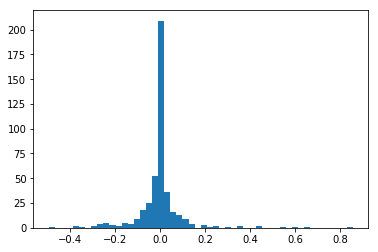

In [148]:
plt.hist(error, bins=50)
plt.show()

In [135]:
#### Generate Vote Fraction Plots of Districts for each State and National ####

vote_fraction_plot_directory = os.path.join(final_directory,"Vote_Fraction_Plots")
if not os.path.exists(vote_fraction_plot_directory):
    os.makedirs(vote_fraction_plot_directory)

districtResults = pd.read_csv(districtResultsPath)

for sID in districtResults.stateID.unique():
    state_districtResults = districtResults[districtResults.stateID==sID]
    state = state_districtResults.iloc[0]['state']
    for mt in state_districtResults.maptype.unique():
        maptype_districtResults = state_districtResults[state_districtResults.maptype==mt]
        state_dem_votefrac = []
        for row in maptype_districtResults.itertuples():
            district_dem_votefrac = float(getattr(row,'district_dem_result'))/(getattr(row,'district_rep_result')+getattr(row,'district_dem_result'))
            state_dem_votefrac.append(district_dem_votefrac)
        plt.plot(range(1,len(state_dem_votefrac)+1),sorted(state_dem_votefrac), marker='o', label=mt)
    plt.axhline(y=0.5, color='r', linestyle='-')
    plt.ylabel('Democrat Vote Fraction')
    #plt.ylim(0,1)
    plt.xlabel('Districts')
    plt.legend()
    title = state+" Democrat Vote Fraction Plot"
    plt.title(title)
    plt.savefig(os.path.join(vote_fraction_plot_directory,title.replace(' ','_')+".png"))
    plt.close()
    
for mt in districtResults.maptype.unique():
    maptype_districtResults = districtResults[districtResults.maptype==mt]
    national_dem_votefrac = []
    for row in maptype_districtResults.itertuples():
        district_dem_votefrac = float(getattr(row,'district_dem_result'))/(getattr(row,'district_rep_result')+getattr(row,'district_dem_result'))
        national_dem_votefrac.append(district_dem_votefrac)
    plt.plot(range(1,len(national_dem_votefrac)+1),sorted(national_dem_votefrac), label=mt)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Democrat Vote Fraction')
#plt.ylim(0,1)
plt.xlabel('Districts')
plt.legend()
title = "National Democrat Vote Fraction Plot"
plt.title(title)
plt.savefig(os.path.join(vote_fraction_plot_directory,title.replace(' ','_')+".png"))
plt.close()

In [133]:
#### Generate Seat Fraction Plot (States vs. Party Seat Stare in State) ####

seat_fraction_plot_directory = os.path.join(final_directory,"Seat_Fraction_Plots")
if not os.path.exists(seat_fraction_plot_directory):
    os.makedirs(seat_fraction_plot_directory)

stateResults = pd.read_csv(stateResultsPath)

for mt in stateResults.maptype.unique():
    maptype_stateResults = stateResults[stateResults.maptype==mt]
    national_dem_seatfrac = []
    for row in maptype_stateResults.itertuples():
        state_dem_seatfrac = float(getattr(row,'state_dem_districts'))/(getattr(row,'state_rep_districts')+getattr(row,'state_dem_districts'))
        national_dem_seatfrac.append(state_dem_seatfrac)
    plt.plot(range(1,len(national_dem_seatfrac)+1),sorted(national_dem_seatfrac), label=mt)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Democrat Seat Fraction')
#plt.ylim(0,1)
plt.xlabel('States')
plt.legend()
title = "National Democrat Seat Fraction Plot"
plt.title(title)
plt.savefig(os.path.join(seat_fraction_plot_directory,title.replace(' ','_')+".png"))
plt.close()

In [149]:
import plotly 
plotly.tools.set_credentials_file(username='ym101', api_key='JmSgVRpzRf7BglysVffB')

In [180]:
import math

districtResults = pd.read_csv(districtResultsPath)

distances = {}
for sID in districtResults.stateID.unique():
    state_districtResults = districtResults[districtResults.stateID==sID]
    state = state_districtResults.iloc[0]['state']
    state_curves = {}
    for mt in state_districtResults.maptype.unique():
        maptype_districtResults = state_districtResults[state_districtResults.maptype==mt]
        state_dem_votefrac = []
        for row in maptype_districtResults.itertuples():
            district_dem_votefrac = float(getattr(row,'district_dem_result'))/(getattr(row,'district_rep_result')+getattr(row,'district_dem_result'))
            state_dem_votefrac.append(district_dem_votefrac)
        curve = sorted(state_dem_votefrac)
        state_curves.update({mt:curve})
    
    Dem_gerrymander_index = 0
    for i in range(len(state_curves['current'])):
        Dem_gerrymander_index += math.pow(state_curves['current'][i] - state_curves['Dem'][i], 2)
    Dem_gerrymander_index = math.pow(Dem_gerrymander_index, 0.5)
    
    GOP_gerrymander_index = 0
    for i in range(len(state_curves['current'])):
        GOP_gerrymander_index += math.pow(state_curves['current'][i] - state_curves['GOP'][i], 2)
    GOP_gerrymander_index = math.pow(GOP_gerrymander_index, 0.5)
    
    distance = min(Dem_gerrymander_index,GOP_gerrymander_index)
    if distance == Dem_gerrymander_index and distance == GOP_gerrymander_index and distance != 0:
        print("Distance Equal",sID)
        distance = 0
    elif distance == Dem_gerrymander_index:
        distance *= -1
    if distance != 0:
        distance = 1/distance
    #else:
    #    print("Distance Zero",sID)
    distances.update({state:distance})
    
    
print(distances.values() / np.linalg.norm(distances.values()))
results = pd.DataFrame.from_dict(distances, orient='index', columns=['Distance'])
results


Distance Equal 33
[-0.09386614 -0.          0.10175416  0.         -0.         -0.06546363
 -0.          0.          0.10619583 -0.21052118  0.04019276  0.
  0.12533962 -0.         -0.1697538  -0.04515713  0.06332063  0.06678827
 -0.          0.55229356 -0.07810692  0.05912064 -0.          0.
  0.         -0.         -0.06399625  0.04236881 -0.06498485  0.42932537
 -0.11007889 -0.155154   -0.06506313  0.         -0.33938911  0.318969
 -0.03608413  0.          0.0493586   0.          0.05802479  0.07839961
  0.10373637 -0.11287699 -0.          0.          0.         -0.18229313
 -0.16706084 -0.        ]


Distance
WA -11.115175
DE  -0.000000
WI  12.049237
WV   0.000000
HI  -0.000000
FL  -7.751887
WY  -0.000000
NH   0.000000
NJ  12.575197
NM -24.928902
TX   4.759432
LA   0.000000
NC  14.842112
ND  -0.000000
NE -20.101426
TN  -5.347289
NY   7.498124
PA   7.908745
RI  -0.000000
NV  65.399939
VA  -9.249044
CO   7.000781
AK  -0.000000
AL   0.000000
AR   0.000000
VT  -0.000000
IL  -7.578128
GA   5.017110
IN  -7.695192
IA  50.838639
MA -13.035011
AZ -18.372588
CA  -7.704462
ID   0.000000
CT -40.188821
ME  37.770770
MD  -4.272908
OK   0.000000
OH   5.844807
UT   0.000000
MO   6.871016
MN   9.283703
MI  12.283960
KS -13.366349
MT  -0.000000
MS   0.000000
SC   0.000000
KY -21.586272
OR -19.782538
SD  -0.000000

In [181]:
scl = [[0, '#1256E0'], [0.16666666666, '#14ADDB'], [0.33333333333, '#FFFFFF'],
            [0.5, '#E09C8F'],[0.66666666666, '#E16873'],[0.83333333333, '#E33457'], [1, "#E5003C"]]

#scl = 'BlueRed'
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = results.index.values,
        z = results['Distance'],
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(0,0,0)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Change in Republican Seats")
        ) ]

layout = dict(
        title = 'House Seat Changes Due to Gerrymandering 2018',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
            showsubunits = False)
             )

fig = dict( data=data, layout=layout )
py.iplot(fig)